# CLASE 2.8 – Selección, evaluación e inspección de modelos.
---
## Introducción.
Hasta ahora, hemos construido una base robusta y muy fuerte que nos permite implementar prácticamente cualquier modelo de aprendizaje superviado a cualquier conjunto de datos de naturaleza tabular. Hemos sido cuidadosos en trabajar los fundamentos teóricos de cada modelo a fin de podernos manejar adecuadamente en cualquier situación. Sin embargo, poco hemos hablado acerca de la selección, evaluación e inspección de modelos, limitándonos a comentar en los ejemplos trabajados en cada sección algunas de las muchísimas opciones que **<font color='mediumorchid'>Scikit-Learn</font>** nos provee. Por supuesto, ésto es peligroso. Tenemos muchas herramientas fuertes en construcción de modelos, pero no nos hemos dedicado a darles brillo comentando en detalle cómo evaluar nuestros modelos en detalle a fin de seleccionar el mejor de ellos. Ni tampoco le hemos sacado provecho a las múltiples herramientas que **<font color='mediumorchid'>Scikit-Learn</font>** nos ofrece para inspeccionar las predicciones que realizan los modelos y entender el "razonamiento" que éstos tienen.

En esta sección nos dedicaremos enteramente a ésto. Será una sección con muchísimo código, mayormente práctica, donde incluso buscaremos simplemente traducir algunos aspectos relevantes de la [documentación](https://scikit-learn.org/stable/model_selection.html) de **<font color='mediumorchid'>Scikit-Learn</font>** que versan sobre estos temas. Sin embargo, aprovecharemos igualmente la oportunidad para introducir uno de los mejores buscadores de hiperparámetros en la industria: **<font color='mediumorchid'>Optuna</font>**-. Un framework de optimización Bayesiana que destaca por su simplicidad y potencia a la hora de encontrar la mejor combinación de hiperparámetros para un modelo determinado.

## Validación cruzada.
Aprender los parámetros que gobiernan una función predictora y testearlos sobre los mismos datos usados para su entrenamiento es un error metodológico: Un modelo que simplemente se limita a repetir las etiquetas de las instancias correspondientes que ha visto durante su construcción, de seguro, tendrá un desempeño cercano a prfecto, pero fallará al predecir cualquier resultado fuera de ese conjunto de datos específico. Esta situación, como bien sabemos, se denomina **overfitting**. Para evitarla, es común que "guardemos" parte de los datos en un conjunto de prueba que será luego utilizado para validar que efectivamente el modelo de interés ha aprendido un patrón intrínseco de los datos que no esté limitado a un conjunto en particular.

En la Fig. (8.1) se muestra un diagrama de flujo típico que muestra el *workflow* derivado de entrenar un modelo. Los mejores hiperparámetros suelen determinarse por medio de la implementación de búsquedas en grillas o aleatorizadas.

<p style="text-align: center;"><img src="figures/fig_8_1.png" width="550"></p>
<p style="text-align: center;">Fig. (8.1): Workflow típico que describe el entrenamiento de un modelo de aprendizaje supervisado</p>

En **<font color='mediumorchid'>Scikit-Learn</font>**, es posible computar rápidamente una división aleatoria entre conjuntos de entrenamiento y de prueba por medio de la función `train_test_split()` (del módulo `sklearn.model_selection`). Para ejemplificar ésto, cargaremos el dataset **<font color='forestgreen'>IRIS</font>** y entrenaremos un modelo de SVM de tipo lineal sobre él:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC

In [3]:
plt.rcParams["figure.dpi"] = 200
sns.set_theme()
plt.style.use("bmh")

In [4]:
%matplotlib widget

In [5]:
# Cargamos el dataset Iris.
X, y = load_iris(return_X_y=True)

In [6]:
# Chequeamos geometrías.
print(f"Geometría de X: {X.shape}")
print(f"Geometría de y: {y.shape}")

Geometría de X: (150, 4)
Geometría de y: (150,)


Podemos seleccionar rápidamente un conjunto de entrenamiento mientras dejarmos un 40% de los datos para testear nuestro modelo:

In [7]:
# Separamos conjuntos de entrenamiento y de prueba.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42,
)

In [8]:
# Chequeamos geometrías.
print(f"Geometría de X_train: {X_train.shape}")
print(f"Geometría de y_train: {y_train.shape}")
print(f"Geometría de X_test: {X_test.shape}")
print(f"Geometría de y_test: {y_test.shape}")

Geometría de X_train: (90, 4)
Geometría de y_train: (90,)
Geometría de X_test: (60, 4)
Geometría de y_test: (60,)


In [9]:
# Entrenamos nuestro modelo.
model = LinearSVC(C=1)
model.fit(X_train, y_train)

LinearSVC(C=1)

In [10]:
# Y evaluamos nuestro modelo en los datos de prueba.
model.score(X_test, y_test)

0.9833333333333333

Cuando evaluamos distintos hiperparámetros para cualquier estimador, como es el caso del parámetro `C` en una máquina de soporte vectorial, aún existe riesgo de generar overfitting sobre el conjunto de prueba, porque los hiperparámetros pueden ser ajustados hasta que logremos un resultado que nos parezca óptimo sobre dichos datos. De esta manera, el conocimiento sobre los datos de prueba puede "filtrarse" hacia el modelo, y las métricas de desempeño ya no nos servirán para evaluar su capacidad de generalización. Para resolver este problema, podemos dejar fuera una parte del conjunto de entrenamiento, denoniminándola como **conjunto de validación**, y luego entrenar nuestros modelos sobre el resto de los datos, evaluando su desempeño sobre los mencionados datos de validación. **Cuando nuestro experimento es exitoso**, ya podemos pensar en evaluar la capacidad de generalización del modelo sobre los datos de prueba.

Sin embargo, al particionar nuestros datos en tres subconjuntos distintos, reducimos drásticamente el número de instancias que serán utilizadas para que el modelo aprenda los patrones de interés, y los resultados podrían depender de cuáles instancias fueron utilizadas para el proceso de entrenamiento y validación.

Una solución para este problema es la implementación del **procedimiento de validación cruzada** (CV). Un conjunto de prueba se deja afuera para una evaluación final, pero ya no necesitamos un único conjunto de validación. En su versión más básica (denominada **validación cruzada con $k$ subconjuntos o "folds"**), el conjunto de entrenamiento se divide en $k$ subconjuntos más pequeños. Luego procedemos como sigue:

- Se entrena un modelo usando $k-1$ subconjuntos como datos de entrenamiento.
- El modelo resultante se valida en el subconjunto remanente (es decir, se usa como conjunto de validación, a fin de verificar métricas de interés).

La métrica de desempeño reportada por este procedimiento es, por tanto, el promedio de los valores calculados en el loop completo de validación, habiendo usado cada uno de los $k$ subconjuntos como validadores y entrenado con los $k-1$ restantes. Este enfoque puede ser computacionalmente muy costoso, pero no desperdicia demasiados datos como sería el caso cuando separamos un número fijo de datos para validar, lo que es una ventaja significativa en problemas tales como de inferencia inversa, donde el número de instancias es bastante pequeño.

<p style="text-align: center;"><img src="figures/fig_8_2.png" width="650"></p>
<p style="text-align: center;">Fig. (8.2): Esquema típico del procedimiento de validación cruzada con $5$ subconjuntos de validación</p>

### Cómputo de métricas post-validación cruzada.
La forma más sencilla de implementar un procedimiento de validacion cruzada en **<font color='mediumorchid'>Scikit-Learn</font>** es por medio de la función `cross_val_score()`, del módulo `sklearn.model_selection`, la que se aplica directamente sobre nuestro estimador.

Volvamos al dataset **<font color='forestgreen'>IRIS</font>** y al modelo linear de máquina de soporte vectorial que definimos previamente. Implementaremos un procedimiento con 5 subconjuntos de validación para identificar los resultados de las métricas post-evaluación usando esta función:

In [11]:
from sklearn.model_selection import cross_val_score

In [12]:
# Definimos nuestro modelo.
model = LinearSVC(C=1, random_state=42)

In [13]:
# Construimos el proceso de CV con 5 subconjuntos.
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)

In [14]:
# Mostramos los resultados de exactitud del modelo.
scores.round(3)

array([0.944, 0.778, 1.   , 0.944, 1.   ])

El puntaje promedio y su desviación estándar son, por tanto,

In [15]:
print("%0.2f de exactitud con una desviación estándar de %0.2f" % (scores.mean(), scores.std()))

0.93 de exactitud con una desviación estándar de 0.08


Por defecto, el puntaje computado en cada iteración del procedimiento de validación cruzada se corresponde con el método `score()` del estimador. Es posible cambiar esto utilizando el parámetro `scoring` como sigue:

In [16]:
# Construimos el proceso de CV con 5 subconjuntos, cambiando la métrica de desempeño.
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, scoring="f1_macro")

In [17]:
# Mostramos los resultados de F1 del modelo.
scores.round(3)

array([0.947, 0.794, 1.   , 0.944, 1.   ])

En el ejemplo, hemos utilizado el puntaje F1 macro-ponderado, que es propio de los modelos multinomiales como es este caso. Para el dataset **<font color='forestgreen'>IRIS</font>**, las tres clases de interés se encuentran perfectamente balanceadas y, por tanto, es razonable que sean muy parecidos en la mayoría de los subconjuntos de validación.

#### La función `cross_validate()` y evaluación de múltiples métricas.
La función `cross_validate()` difiere de `cross_val_score()` en dos puntos esenciales:

- Permite evaluar varias métricas de desempeño en vez de sólo una.
- Retorna un diccionario que contiene tiempos de ajuste, tiempos de evaluación (y, opcionalmente, puntajes sobre el conjunto de entrenamiento, estimadores ya ajustados e índices de división entre datos de entrenamiento y de prueba).

Para la evaluación de una única métrica, cuando el parámetro de *scoring* es un string, un *callable* o nada (literalmente `None`), las llaves correspondientes del diccionario retornado serán `['test_score', 'fit_time', 'score_time']`. Mientras que, para evaluar múltiples métricas, el valor a retornar será un diccionario con las llaves `['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']`.

Se setea `return_train_score` en `False` por defecto para ahorrar tiempo de cómputo. Para evaluar los puntajes en el conjunto de entrenamiento, simplemente debemos revertir la opción anterior a `True`. También podemos retener el estimador ajustado en cada conjunto de entrenamiento seteando `return_estimator=True`. Similarmente, podemos setear `return_indices=True` para retener los índices de entrenamiento y de prueba utilizados para dividir el conjunto de datos original para cada *fold*.

Las métricas pueden especificarse por medio de una lista de Python:

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

In [19]:
# Definimos los puntajes a evaluar.
scoring = ['precision_macro', 'recall_macro']

# Definimos nuestro modelo.
model = LinearSVC(C=1, random_state=42)

# Obtenemos los puntajes post-validación cruzada.
scores = cross_validate(model, X, y, scoring=scoring)

# Mostramos esta lista de puntajes.
print(f"Precisiones: {scores['test_precision_macro']}")
print(f"Sensibilidades: {scores['test_recall_macro']}")

Precisiones: [1.         1.         0.93333333 0.9023569  1.        ]
Sensibilidades: [1.         1.         0.93333333 0.9        1.        ]


#### Obtención de predicciones post-validación cruzada.
La función `cross_val_predict()` dispone de una interfaz similar a `cross_val_score()`, pero retorna, para cada elemento en su entrada, la predicción que fue obtenida para dicho elemento cuando fue utilizada como conjunto de validación. Sólo pueden utilizarse estategias de validación cruzada que asignen todos los elementos al conjunto de validación correspondiente exactamente una vez. En otro caso, se levantará una excepción.

Esta función es adecuada para:

- Visualización de predicciones obtenidas para modelos diferentes.
- Mezcla de modelos: Cuando las predicciones de un modelo de aprendizaje supervisado son utilizadas para entrenar otro estimador en métodos de ensamble.

**Ejemplo 8.1 – Curva ROC con validación cruzada:** En este ejercicio, presentaremos como estimar y visualizar la varianza de la curva característica relativa-operativa (ROC) de un modelo por medio de un procedimiento de validación cruzada.

Las cruvas ROC, típicamente, se construyen en un dominio –denominado **espacio ROC**–, constituido por la tasa de verdaderos positivos en el eje $x$ y la tasa de falsos positivos en el eje $y$. Esto significa que la esquina superior izquierda del gráfico es el "punto ideal" de clasificación para un modelo, con una tasa de verdaderos positivos del 100%. Esto no es muy realista, pero implica que una mayor área bajo la curva ROC (AUC), usualmente, describe a un clasificador mejor. La "pendiente" de una curva ROC también es importante, sobre todo si es muy escalonada, ya que es ideal maximizar la tasa de verdaderos positivos al mismo tiempo que minimizamos la tasa de falsos positivos.

Este ejercicio muestra el resultado de una curva ROC en distintos conjuntos de datos, a partir de un procedimiento de validación cruzada con $k$ *folds*. Tomando todas estas curvas, es posible calcular el AUC promedio y verificar la varianza de la curva cuando el conjunto de entrenamiento se divide en distintos subconjuntos. Esto, aproximadamente, nos muestra cómo la salida de un clasificador se afecta debido a cambios en los datos de entrenamiento, y qué tan distintas son las divisiones realizadas por medio de una validación cruzada.

Trabajaremos nuevamente con el dataset **<font color='forestgreen'>IRIS</font>**, el cual contiene tres clases de interés. Una clase es linealmente separable respecto de las otras dos, pero esto no se cumple en el resto. Binarizaremos nuestro dataset al no considerar las flores de la subespecie `Iris virginica` (`class_id=2`). Esto significa que la clase `versicolor` (`class_id=1`) se asume como la clase positiva, mientras que la clase `setosa` (`class_id=0`) se asume como la clase negativa:

In [20]:
# Cargamos el dataset Iris.
iris = load_iris()

# Definimos los nombres de cada clase.
target_names = iris["target_names"]

# Definimos los pares (X, y).
X, y = iris["data"], iris["target"]

In [21]:
# Binarizamos nuestro target.
X, y = X[y != 2], y[y != 2]

In [22]:
# Determinamos el número de instancias (`m`) y el número de variables (`n`)
m, n = X.shape

Añadimos igualmente algunas variables que serán puro ruido, a fin de que el problema sea mucho más difícil de resolver:

In [23]:
# Definimos una semilla aleatoria fija.
rng = np.random.default_rng(seed=42)

# Añadimos las variables con ruido.
X = np.concatenate(
    [X, rng.standard_normal(size=(m, 200 * n))],
    axis=1,
)

A continuación, entrenaremos una máquina de soporte vectorial, y luego usaremos los resultados generados post-validación cruzada para graficar las curvas ROC para cada *fold*. Notemos que la línea base para definir una curva ROC resultante únicamente de adivinar los resultados es simplemente un clasificador que predice la clase más frecuente:

In [24]:
from sklearn.base import clone
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

In [25]:
# Definimos el número de 'folds'.
n_splits = 6

# Definimos la estrategia de validacion cruzada (en este caso, estratificada).
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Definimos nuestro modelo.
model = SVC(kernel="linear", probability=True, random_state=42)

Ahora construimos los espacios ROC para cada curva y obtenemos las correspondientes tasa de verdaderos y falsos positivos, así como las áreas bajo las curvas ROC:

In [26]:
# Recolectamos las tasas de verdaderos y falsos positivos, así como las áreas bajo las curvas ROC
# para cada `fold`.
fprs, tprs, aucs = [], [], []
for tr_idx, te_idx in cv.split(X, y):
    estimator = clone(model)
    estimator.fit(X[tr_idx], y[tr_idx])

    # Chequeamos que el estimador utilizado prediga probabilidades de clase.
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X[te_idx])[:, 1]

    # Sino es así, usamos la función de decisión.
    elif hasattr(estimator, "decision_function"):
        y_score = estimator.decision_function(X[te_idx])
    else:
        raise ValueError(
            "El estimador no expone ni predict_proba() ni decision_function() como métodos válidos."
        )
    # Construimos el espacio ROC.
    fpr, tpr, _ = roc_curve(y[te_idx], y_score)

    # Almacenamos los valores obtenidos.
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[te_idx], y_score))

Por medio de una interpolación sencilla, estimamos las tasas de falsos positivos asociadas a las tasas de verdaderos positivos definidas manualmente:

In [27]:
# Interpolamos los correspondientes valores de tasa de falsos positivos.
mean_fpr = np.linspace(start=0, stop=1, num=101)
interp_tprs = []
for fpr, tpr in zip(fprs, tprs):
    interp = np.interp(mean_fpr, fpr, tpr)
    interp[0] = 0.0
    interp_tprs.append(interp)

A continuación, determinamos la curva ROC promedio y su banda de variabilidad:

In [28]:
# Calculamos los valores medios y desviación de la tasa de verdaderos positivos.
mean_tpr = np.mean(interp_tprs, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(interp_tprs, axis=0)

# Hacemos lo mismo para las áreas bajo las curvas ROC.
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Definimos los bordes de la banda de variabilidad de las curvas.
tprs_upper = np.minimum(mean_tpr + std_tpr, 1.0)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0.0)

Y mostramos los resultados en un gráfico:

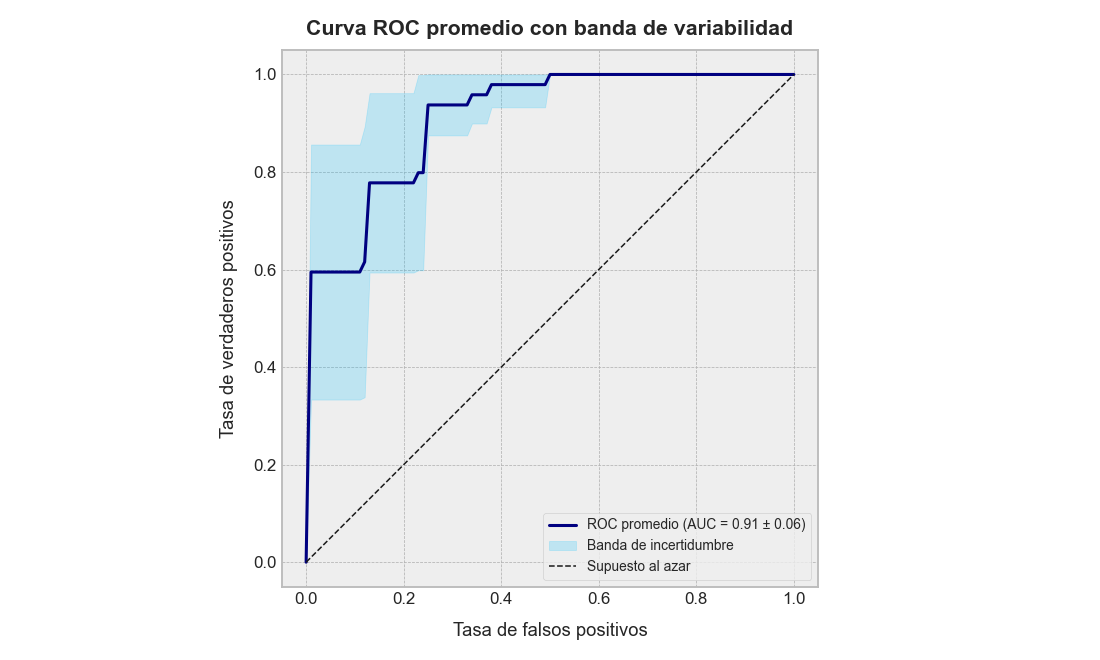

In [29]:
# Y visualizamos nuestros resultados.
fig, ax = plt.subplots(figsize=(10, 6), dpi=110)
ax.plot(
    mean_fpr, mean_tpr, lw=2, color="navy",
    label=f"ROC promedio (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)
ax.fill_between(
    mean_fpr, tprs_lower, tprs_upper, alpha=0.2, color="deepskyblue",
    label="Banda de incertidumbre")
ax.plot([0, 1], [0, 1], ls="--", lw=1, color="k", label="Supuesto al azar")
ax.set_xlabel("Tasa de falsos positivos", fontsize=12, labelpad=10)
ax.set_ylabel("Tasa de verdaderos positivos", fontsize=12, labelpad=10)
ax.set_title("Curva ROC promedio con banda de variabilidad", fontsize=14, fontweight="bold", pad=10)
ax.legend(loc="lower right", fontsize=9, frameon=True)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout();

Podemos observar que las curvas ROC pueden ser muy variables por *fold*, con una banda de variabilidad que es especialmente grande cuando la tasa de falsos positivos está en en el intervalo $(0, 0.25)$. Esto muestra que cada subconjunto de entrenamiento escogido, a pesar de que la validación cruzada se realiza de forma estratificada, no presenta el mismo balance de clases. ◼︎

### Iteradores de validación cruzada.
A continuación, listaremos algunas utilidades para generar índices que pueden ser udados para generar divisiones de conjuntos de datos de acuerdo a diversas estrategias de validación cruzada.

#### Iteradores para datos iid.
Si asumimos que nuestro conjunto de datos es independiente e idénticamente distribuido (iid), lo que implica que todas las instancias son generadas por el mismo proceso estocástico, sin que éste tenga "memoria" de instancias generadas previamente, entonces podemos utilizar los siguientes iteradores:

**(I) `KFold`:** El iterador `KFold` divide todas las instancias de interés en $k$ grupos de muestras, denominadas *folds* (si tenemos $m$ instancias en total, entonces el caso $k=m$ es llamado **estrategia de tipo "leave-one-out"**) que, en lo posible, tienen el mismo tamaño. La función predictora es entonces entrenada utilizando $k-1$ *folds*, dejando el restante como conjunto de validación.

<p style="text-align: center;"><img src="figures/fig_8_3.png" width="650"></p>
<p style="text-align: center;">Fig. (8.3): Esquema de una estrategia de validación cruzada de tipo `KFold`</p>

Por ejemplo, para `2` *folds* con `4` instancias:

In [30]:
from sklearn.model_selection import KFold

In [31]:
# Definimos las instancias.
X = ["a", "b", "c", "d"]

# Definimos la estrategia de validación cruzada.
cv = KFold(n_splits=2)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X):
    print("%s %s" % (train_idx, test_idx))

[2 3] [0 1]
[0 1] [2 3]


**(II) `RepeatedKFold`:** La clase `RepeatedKFold` replica `KFold` un total de $n$ veces, produciendo distintos splits en cada repetición. Por ejemplo, para una validación cruzada con `2` *folds*, repetida dos veces:

In [32]:
from sklearn.model_selection import RepeatedKFold

In [33]:
# Generamos un arreglo 2D que emulará información de entrada.
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])

# Definimos la estrategia de validación cruzada.
cv = RepeatedKFold(n_splits=2, n_repeats=2, random_state=42)

# Mostramos las instancias asociadas a cada subconjunto, con sus repeticiones.
for train_idx, test_idx in cv.split(X):
    print("%s %s" % (train_idx, test_idx))

[0 2] [1 3]
[1 3] [0 2]
[0 2] [1 3]
[1 3] [0 2]


Similarmente, `RepeatedStratifiedKFold` replica `StratifiedKFold` un total de $n$ veces con aleatorización distinta en cada repetición.

**(III) Estrategia de tipo Leave-One-Out (LOO):** `LeaveOneOut` (abreviada como LOO) es una estrategia de validacion cruzada sencilla en la cual cada conjunto de entrenamiento se crea tomando todas las instancias disponibles con excepción de una, en la cual testeamos nuestros resultados. Si disponemos de un conjunto de datos con $m$ instancias, dejamos una afuera y entrenamos en las $m-1$ restantes, repitiendo ste proceso hasta haber validado los resultados de nuestro modelo con cada una de las instancias de entrenamiento. Es, por definición, la estrategia que menos datos desperdicia en cada *fold*:

In [34]:
from sklearn.model_selection import LeaveOneOut

In [35]:
# Generamos un sencillo arreglo que emulará los datos de entrada.
X = [1, 2, 3, 4]

# Definimos la estrategia de validación cruzada.
cv = LeaveOneOut()

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X):
    print("%s %s" % (train_idx, test_idx))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


Hay algunos casos a considerar cuando pretendemos implementar una estrategia de tipo LOO. Cuando comparamos estrategia con una validación cruzada de tipo `KFold`, construimos $m$ modelos en vez de $k$ modelos, donde $m>k$. Además, cada uno es entrenado en un total de $m-1$ instancias en vez de $(k-1)m/k$. En ambos casos, asumiendo que $k$ no es demasiado grande y $k<m$, una estrategia de tipo LOO es mucho más cotosa computacionalmente que una de tipo `KFold`.

En términos de exactitud, LOO con frecuencia ofrece resultados con alta varianza para los estimadores que se testean sobre la instancia de validación. Intuitivamente, dado que $m-1$ de las $m$ instancias son utilizadas para construir cada modelo, los modelos resultan virtualmente idénticos y a un hipotético modelo construido a partir del conjunto de entrenamiento completo.

Como regla general, muchos expertos coinciden en que una validación cruzada de tipo `KFold` con 5 a 10 *folds*  debiera preferirse a una validación de tipo LOO.

**(IV) Estrategia de tipo Leave-P-Out (LPO):** `LeavePOut` es muy similar a `LeaveOneOut`, ya que crea todos los conjuntos posibles de entrenamiento y de prueba removimiendo $p$ instancias del conjunto de datos completo. Para un total de $m$ instancias de entrenamiento, esto produce un total de $\left( {}_{p}^{m} \right)$ pares "entrenamiento-prueba". A diferencia de `LeaveOneOut` y `KFold`, los conjuntos de validación comenzarán a superponerse a partir de $p>1$.

A continuación, un pequeño ejemplo de una validación cruzada de tipo `LeavePOut` con $p=2$ en un dataset con `4` instancias:

In [36]:
from sklearn.model_selection import LeavePOut

In [37]:
# Generamos un sencillo arreglo que emulará los datos de entrada.
X = [1, 2, 3, 4]

# Definimos la estrategia de validación cruzada.
cv = LeavePOut(p=2)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X):
    print("%s %s" % (train_idx, test_idx))

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


**(V) Estrategia con permutaciones aleatorizadas (*shufle & split*):** El iterador `ShuffleSplit` permite generar un número definido de *splits* de entrenamiento/validación. Las instancias son primero mezcladas (como una baraja de naipes) y luego separadas.

Es posible controlar la aleatoriedad por medio de una semilla aleatoria prefijada, a fin de que los resultados sean reproducibles:

In [38]:
from sklearn.model_selection import ShuffleSplit

In [39]:
# Generamos un sencillo arreglo que emulará los datos de entrada.
X = np.arange(start=0, stop=10, step=1)

# Definimos la estrategia de validación cruzada.
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X):
    print("%s %s" % (train_idx, test_idx))

[0 7 2 9 4 3 6] [8 1 5]
[5 3 4 7 9 6 2] [0 1 8]
[6 8 5 3 7 1 4] [9 2 0]
[2 8 0 3 4 5 9] [1 7 6]
[8 0 7 6 3 2 9] [1 5 4]


<p style="text-align: center;"><img src="figures/fig_8_4.png" width="650"></p>
<p style="text-align: center;">Fig. (8.4): Esquema de una estrategia de validación cruzada de tipo `Shuffle & Split`</p>

Se tiene pues que `ShuffleSplit` es una muy buena alternativa a `KFold`, y que permite un control más fino sobre el número de iteraciones del procedimiento de validación cruzada y de la proporción de muestras que son dejadas como datos de validación.

#### Iteradores para validación cruzada estratificada.
Algunos problemas de clasificación pueden exhibir, en algunos casos, clases con una frecuencia excepcionalmente baja. Esto es propio de **problemas no balanceados**, donde la clase positiva es varios órdenes de magnitud menos frecuente que la clase negativa, lo que es común e problemas de mantenimiento predictivo (detección de fallas), detección de fraudes, entre otros. Como resultado, la división de un conjunto de entrenamiento por medio de un procedimiento de validación cruzada puede resultar contraproducente, porque puede derivar en subconjuntos sin una o más clases de interés. Esto típicamente produce la indeterminación de varias métricas de desempeño, lo que se traduce en excepciones levantadas por **<font color='mediumorchid'>Scikit-Learn</font>**.

Para mitigar estos problemas, **<font color='mediumorchid'>Scikit-Learn</font>** nos provee de iteradores especializados, como `StratifiedKFold` y `StratifiedShuffleSplit`, que permiten implementar técnicas de muestreo estratificado para preservar la proporción de las categorías en cualquier variable de este tipo al dividir un conjunto de entrenamiento, siempre que ésto sea posible.

**(I) `StratifiedKFold`:** La clase `StratifiedKFold` es una variante de `KFold` que retorna *folds* estratificados, donde se preserva la proporción de categorías de cualquier variable (no solamente la de respuesta).

A continuación se muestra un ejemplo en el cual se implementa una validación estratificada con `3` *folds* a un conjunto de datos con una variable de respuesta desbalanceada de tipo binaria:

In [40]:
from sklearn.model_selection import StratifiedKFold

In [41]:
# Definimos la matriz de diseño X y el vector de valores de respuesta y.
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))

# Definimos la estrategia de validación cruzada.
cv = StratifiedKFold(n_splits=3)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X, y):
    print(
        'train -  {}   |   test -  {}'
        .format(
            np.bincount(y[train_idx]), np.bincount(y[test_idx])
        )
    )

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


In [42]:
# Si hubiéramos hecho simplemente `KFold`, la repartición hubiera sido la siguiente.
cv = KFold(n_splits=3)
for train_idx, test_idx in cv.split(X, y):
    print(
        'train -  {}   |   test -  {}'
        .format(
            np.bincount(y[train_idx]), np.bincount(y[test_idx])
        )
    )

train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


Podemos observar que `StratifiedKFold` preserva siempre los *ratios* entre las clases positiva y negativa (aproximadamente 1/10). En el caso de `KFold`, los primeros dos *folds* no presentaban instancias asociadas a la clase positiva, lo que hubiera levantado errores en el procedimiento en forma posterior.

<p style="text-align: center;"><img src="figures/fig_8_5.png" width="650"></p>
<p style="text-align: center;">Fig. (8.5): Esquema de una estrategia de validación cruzada de tipo `StratifiedKFold`</p>

**(II) `StratifiedShuffleSplit`:** La clase `StratifiedShuffleSplit` permite, al igual que `StratifiedKFold`, implementar un procedimiento de validación cruzada estratificada. Sin embargo, la diferencia clave es que, en cada repetición, se realiza una mezcla completa de los datos de entrenamiento, de modo tal que existe siempre cierto nivel de superposición entre los distintos conjuntos de entrenamiento y de validación, aunque siempre preservando el *ratio* de categorías de interés.

#### Iteradores para datos agrupados.
El supuesto de independencia y distribución idéntica (iid) que es inherente a nustros conjuntos de datos se rompe si el proceso que los genera produce grupos de muestras que son dependientes entre sí

Tal agrupamiento de datos es específico de un dominio dado. Un ejemplo sería cuando hay datos médicos coleccionados de múltiples pacientes, con múltiples muestras tomadas de cada paciente. Por supuesto, un conjunto de datos así, lo más probable, es que sea dependiente de un grupo individual. En nuestro caso, el ID de un paciente para cada muestra sería su identificador de grupo.

En este caso, es interesante saber si un modelo entrenado en un conjunto particular de grupos es capaz de generalizar bien su aprendizaje a grupos nuevos. Para medir esto, necesitamos garantizar que todas las muestras en el conjunto de validación vengan de grupos que no están representados en los *folds* de entrenamiento.

Los siguientes iteradores provistos por **<font color='mediumorchid'>Scikit-Learn</font>** son capaces de tratar este tipo de problemas. El identificador de grupo para las instancias correspondientes se especifica siempre por medio del parámetro `groups`:

**(I) `GroupKFold`:** `GroupKFold` es una variación de `KFold` que garantiza que el mismo grupo de instancias no esté representado en el par entrenamiento-validación. Por ejemplo, si nuestros datos se obtienen a partir de diferentes "sujetos" de interés, con varias instancias por "sujeto", y si el modelo es lo suficientemente flexible para aprender atributos específicos de cada uno, entonces podría fallar en generalizar su aprendizaje a sujetos nuevos. La clase `GroupKFold` evita este problema, detectando estos eventuales casos de overfitting.

Imaginemos que disponemos de tres "sujetos", cada uno asociado a un número que va del `1` al `3`:

In [43]:
from sklearn.model_selection import GroupKFold

In [44]:
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10] # Datos de entrada.
y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"] # Datos de salida.
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3] # Grupos de interés.

# Definimos la estrategia de validación cruzada.
cv = GroupKFold(n_splits=3)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X, y, groups=groups):
    print("%s %s" % (train_idx, test_idx))

[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


Notemos que cada "sujeto" se encuetra en un único *fold* de validación, y el mismo "sujeto" nunca está simultáneamente en el conjunto de entrenamiento y de validación. Notemos que los *folds* no necesariamente tendrán el mismo tamaño debido a que los datos son propios de un problema no balanceado. Si las proporciones de las clases deben balancearse entre *folds*, es mejor procede con una validación cruzada por grupos de tipo estratificada, como veremos más adelante.

<p style="text-align: center;"><img src="figures/fig_8_6.png" width="650"></p>
<p style="text-align: center;">Fig. (8.6): Esquema de una estrategia de validación cruzada de tipo `GroupedKFold`</p>

**(II) `StratifiedGroupKFold`:** `StratifiedGroupKFold` es un esquema de validación cruzada que combina `StratifiedKFold` con `GroupKFold`. La idea es intentar preservar la distribución de las clases en cada split mientras mantenemos cada grupo dentro de un único split. Esto puede ser útil cuando tenemos un dataset no balanceado, tal que el uso de sólo ´GroupKFold´ produciría splits asimétricos.

Por ejemplo:

In [45]:
from sklearn.model_selection import StratifiedGroupKFold

In [46]:
# Generamos el arreglo con datos de entrada y de salida, además de los grupos.
X = list(range(18))
y = [1] * 6 + [0] * 12
groups = [1, 2, 3, 3, 4, 4, 1, 1, 2, 2, 3, 4, 5, 5, 5, 6, 6, 6]

# Definimos la estrategia de validación cruzada.
cv = StratifiedGroupKFold(n_splits=3)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X, y, groups=groups):
    print("%s %s" % (train_idx, test_idx))

[ 0  2  3  4  5  6  7 10 11 15 16 17] [ 1  8  9 12 13 14]
[ 0  1  4  5  6  7  8  9 11 12 13 14] [ 2  3 10 15 16 17]
[ 1  2  3  8  9 10 12 13 14 15 16 17] [ 0  4  5  6  7 11]


**(III) `LeaveOneGroupOut`:** `LeaveOneGroupOut` es un esquema de validación cruzada similar a `LeaveOneOut`, con la diferencia de que, en vez de dejar una única instancia afuera como validación en cada iteración, deja un grupo específico afuera. Cada subconjunto de entrenamiento es por tanto constituido por todas las instancias, salvo aquellas relacionadas a un único grupo.

Por ejemplo, en el caso de experimentos múltiples, `LeaveOneGroupOut` puede usarse para crear un esquema de validación cruzada basado en los experimentos individuales: Creamos un conjunto de entrenamiento usando todas las instancias de cada experimentos, con excepción de uno:

In [47]:
from sklearn.model_selection import LeaveOneGroupOut

In [48]:
# Creamos un areglo de entrada y salida, y los grupos correspondientes.
X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]

# Creamos el esquema de validación cruzada.
cv = LeaveOneGroupOut()

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X, y, groups=groups):
    print("%s %s" % (train_idx, test_idx))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


**(IV) `LeavePGroupsOut`:** `LeavePGroupsOut` es similar a `LeaveOneGroupOut`, pero remueve aquellas muestras que están asociadas a $p$ grupos para cada división entre subconjunto de entrenamiento y de validación. Todas las posibles combinaciones de esos $p$ grupos quedan fuera, lo que significa que los subconjuntos de validación comenzarán a superponerse cuando $p>1$:

In [49]:
from sklearn.model_selection import LeavePGroupsOut

In [50]:
# Creamos un areglo de entrada y salida, y los grupos correspondientes.
X = np.arange(6)
y = [1, 1, 1, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3]

# Creamos el esquema de validación cruzada.
cv = LeavePGroupsOut(n_groups=2)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in cv.split(X, y, groups=groups):
    print("%s %s" % (train_idx, test_idx))

[4 5] [0 1 2 3]
[2 3] [0 1 4 5]
[0 1] [2 3 4 5]


#### Validación cruzada para series de tiempo.
`TimeSeriesSplit` es una variante de `KFold` que retorna los primeros $k$ *folds* como conjunto de entrenamiento, siendo el *fold* $k+1$ el conjunto de validación. Notemos que, a diferencia de los esquemas clásicos de validación cruzada vistos previamente, los conjuntos de entrenamiento subsecuentes son superconjuntos de aquellos que fueron definidos previamente. Además, añade el exceso de datos a la primera partición de entrenamiento, la que siempre se utiliza para entrenar nuestro modelo.

Notemos que cada *fold* de validación tiene siempre una duración fija, a fin de disponer de métricas comparables para cada iteración.

A continuación, un ejemlo de validación cruzada en series de tiempo con `3` *folds* en un conjunto de datos con `6` instancias:

In [51]:
from sklearn.model_selection import TimeSeriesSplit

In [52]:
# Creamos los datos de entrada y salida.
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

# Construimos el esquema de validación cruzada.
tscv = TimeSeriesSplit(n_splits=3)

# Mostramos las instancias asociadas a cada subconjunto.
for train_idx, test_idx in tscv.split(X):
    print("%s %s" % (train_idx, test_idx))

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


<p style="text-align: center;"><img src="figures/fig_8_7.png" width="650"></p>
<p style="text-align: center;">Fig. (8.7): Esquema de una estrategia de validación cruzada de tipo `TimeSeriesSplit`</p>

## Ajuste de hiperparámetros en un esquema de validación cruzada.
LOs **hiperparámetros** son parámetros que no son aprendidos en el proceso de entrenamiento de un modelo, sino que deben setearse manualmente. En **<font color='mediumorchid'>Scikit-Learn</font>**, los hiperparámetros son pasados como argumentos en el constructor de un modelo. Ejemplos típicos de hiperparámetros son `C` en las máquinas de soporte vectorial, `max_depth` en un ensamble con base en árboles o `l1_ratio` en un modelo de red elástica, entre otros.

En **<font color='mediumorchid'>Scikit-Learn</font>**, es posible buscar la mejor combinación de hiperparámetros a partir de un procedimiento de validación cruzada, en la cual se testea un número previamente de distintas permutaciones entre tales hiperparámetros.

Cualquier parámetro que sea pasado al constructor de un modelo puede optimizarse de esta manera. Específicamente, para encontrar los nombres y valores actuales de un estimador dado, digamos `model`, usamos:

```
model.get_params()
```

Una búsqueda típica de **<font color='mediumorchid'>Scikit-Learn</font>** consiste de:

- Un estimador (un regresor o clasificador).
- Un **espacio de búsqueda** de hiperparámetros.
- Un método de búsqueda de candidatos.
- Un esquema de validación cruzada.
- Una función de *scoring*.

Dos enfoques genéricos para la búsqueda de hiperparámetros son provistos por **<font color='mediumorchid'>Scikit-Learn</font>**: Para un espacio de búsqueda dado, `GridSearchCV` considera exhaustivamente todas las combinaciones provistas en el espacio de búsqueda, mientras que `RandomizedSearchCV` puede muestrear una cantidad previamente definida de combinaciones dadas distribuciones de probabilidad que describan los valores de esos hiperparámetros. Ambas herramientas poseen contrapartes con menor costo computacional denominadas `HalvingGridSearchCV` y `HalvingRandomSearchCV`, que realizan búsquedas secuenciales y descartan los peores candidatos, ahorrando mucho tiempo de ejecución. Estas dos contrapartes son **experimentales**, y requieren activar algunos métodos específicos del módulo `sklearn.experimental` para ser utilizados.

### Búsqueda exhaustiva por grillas (`GridSearchCV`).
La búsqueda exhaustiva provista por `GridSearchCV` genera candidatos de forma determinista a partir de un espacio de búsqueda que se asume como una grilla $r$-dimensional, donde $r$ es la cantidad de hiperparámetros a buscar. Tal espacio se explicita en el constructor por medio de un diccionario de Python denominado `param_grid`:

In [53]:
# Para una SVM, definimos una grilla de búsqueda.
param_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

El diccionario anterior explicita dos grillas que deben ser evaluadas de forma exhaustiva: Una que consta de los hiperparámetros `C` y `kernel`, para los cuales proveemos valores fijos en forma de listas de Python; y otra que consta de los hiperparámetros `C` y `gamma`. La búsqueda se denomina "exhaustiva" porque cada valor de las listas se explora en combinación con otros. Ninguna combinación se deja fuera de la evaluación.

`GridSearch` implementa la misma API estimadora que otros modelos en **<font color='mediumorchid'>Scikit-Learn</font>**. Para iniciar la búsqueda usamos el método `fit()`. Una vez terminada la búsqueda, hay métodos para generar predicciones como `predict()` o `predict_proba()`, aunque es más recomendable aislar el "mejor" modelo encontrado en un objeto separado, por trazabilidad y legibilidad de nuestro código.

**Ejemplo 8.2 – ¿Cómo se ve una búsqueda por grillas?** La búsqueda exhaustiva de hiperparámetros siempre genera una grilla perfectamente hiperrectangular a nivel gráfico. Cada punto de la grilla es una evaluación que se realiza por medio de validación cruzada. Por lo tanto, si tuviéramos `3` hiperparámetros de interés que optimizar, el resultado sería una grilla 3D con forma ortoedral.

Pongamos esto en práctica y consideremos el dataset **<font color='forestgreen'>IRIS</font>** (como tantas otras veces). Añadiremos algo de ruido para hacer el problema más difícil y construiremos una grilla de búsqueda exhaustiva a partir del ajuste de `3` hiperparámetros de un modelo de árbol de decisión:

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [55]:
# Cargamos el dataset Iris.
iris = load_iris()

# Definimos los nombres de cada clase.
target_names = iris["target_names"]

# Definimos los pares (X, y).
X, y = iris["data"], iris["target"]

In [56]:
# Determinamos el número de instancias (`m`) y el número de variables (`n`)
m, n = X.shape

# Definimos una semilla aleatoria fija.
rng = np.random.default_rng(seed=42)

# Añadimos las variables con ruido.
X = np.concatenate(
    [X, rng.standard_normal(size=(m, 200 * n))],
    axis=1,
)

A continuación definimos la grilla de búsqueda exhaustiva. En este caso, fijamos la búsqueda para los hiperparámetros `max_depth`, `min_samples_split` y `min_samples_leaf` de un árbol de clasificación. Notemos que si una grilla está constituida por $p$ hiperparámetros, y para cada hiperparámetro $p_{k}$ se tiene una lista de $r_{k}$ valores a testear, en un esquema de validación cruzada con $n$ *folds*, entonces el número total de evaluaciones realizadas por `GridSeachCV` es

$$N_{\mathrm{evaluaciones}}=n\prod_{k=1}^{p} r_{k} \tag{8.1}$$

Continuemos:

In [57]:
# Determinamos la grilla de búsqueda.
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9],
    "min_samples_split": [2, 4, 8, 16, 32],
    "min_samples_leaf": [1, 2, 4, 8, 16],
}

A continuación definimos nuestro modelo base, que será el mencionado árbol de clasificación. Notemos que, al ser un modelo de base, únicamente definiremos su seilla aleatoria fija. Todos los demás hiperparámetros de interés se ajustarán vía `GridSearchCV`:

In [58]:
# Inicializamos un modelo de árbol de decisión.
model = DecisionTreeClassifier(random_state=42)

A continuación definimos nuestra búsqueda exhaustiva. La clase `GridSearchCV` acepta, entre otros, los siguientes argumentos:

- `estimator`: Estimador de **<font color='mediumorchid'>Scikit-Learn</font>** para el cual ajustaremos los hiperparámetros.
- `param_grid`: Diccionario de Python que describe la grilla de búsqueda a implementar.
- `scoring`: Puntaje a evaluar en cada *fit* del modelo sobre los datos de validación en el esquema de validación cruzada. En nuestro ejemplo, usaremos `"f1_macro"`, que corresponde a un puntaje F1 macro-ponderado, ideal para problemas de clasificación multinomial.
- `n_jobs`: Número de procesadores que serán usados en la búsqueda exhaustiva. `n_jobs=-1` implica que se utilizan todos los disponibles.
- `refit`: Permite reajustar un modelo usando los mejores hiperparámetros encontrados conforme una métrica determinada. Si se usaron múltiples métricas para evaluar la búsqueda vía el parámetro `scoring`, en `refit` debe señalarse sólo una.
- `cv`: Permite definir la estrategia de validación cruzada que domina la búsqueda. Por defecto, si fijamos un entero `n`, entonces se aplicará una estrategia de tipo `KFold` con `n` *folds*. Es posible imputar la clase asociada a una estrategia, a fin de usar validación estratificada o por grupos, incluso para series de tiempo.

In [59]:
# Definimos nuestro buscador.
searcher = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
)

Para implementar la búsqueda, usamos el método `fit()`, igual que en cualquier modelo:

In [60]:
# Y realizamos la búsqueda.
searcher.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16, 32]},
             scoring='f1_macro')

Los resultados de la búsqueda pueden recuperarse usando el atributo `cv_results_` una vez que ésta ha finalizado. Por simplicidad, pasaremos los resultados a un DataFrame de **<font color='mediumorchid'>Pandas</font>**:

In [61]:
# Recuperamos los resultados de esta evaluación.
results = pd.DataFrame(searcher.cv_results_)

In [62]:
# Verificamos las primeras filas de estos resultados.
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026824,0.002877,0.003053,0.000107,2,1,2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,1
1,0.024995,0.000137,0.003061,0.000237,2,1,4,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,1
2,0.024722,0.000109,0.002808,0.000079,2,1,8,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,1
3,0.024586,0.000040,0.002785,0.000033,2,1,16,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,1
4,0.024619,0.000123,0.002761,0.000011,2,1,32,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,1


Notemos que las columnas detallan varios aspectos de la búsqueda, como el tiempo de cómputo (`mean_fit_time`, `std_fit_time`, `mean_score_time` y `std_score_time`), los valores de los hiperparámetros (`param_max_depth`, `param_min_samples_leaf` y `param_min_samples_split`), el resumen de hiperparámetros (`params`), los puntajes en cada *fold* de validación (`split<j>_test_score`), sus valores medios y desviaciones (`mean_test_score` y `std_test_score`) y en ranking asociado a cada combinación (`rank_test_score`). Para observar la regularidad de esta grilla de búsqueda, generamos un gráfico del espacio de búsqueda, pintando cada punto con el valor medio del F! macro-ponderado en los *folds* de validación:

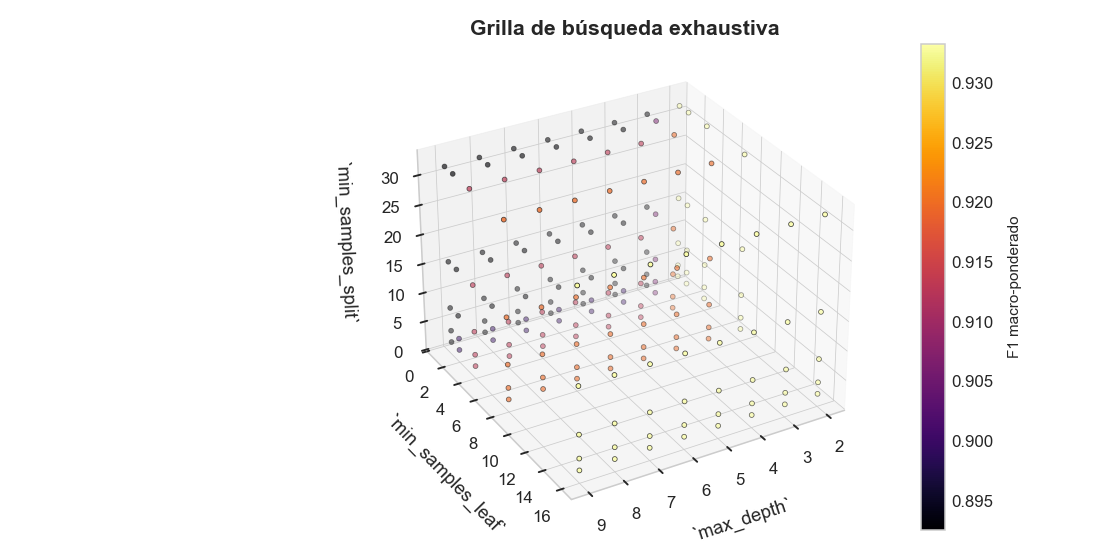

In [63]:
# Visualizamos la grilla completa de búsqueda.
with plt.style.context("seaborn-v0_8-whitegrid"):
    fig = plt.figure(figsize=(10, 5), dpi=110)
    ax = fig.add_subplot(projection="3d")
    p = ax.scatter(
        results["param_max_depth"],
        results["param_min_samples_leaf"],
        results["param_min_samples_split"],
        c=results["mean_test_score"],
        s=10,
        lw=0.5,
        ec="k",
        cmap="inferno"
    )
    cb = fig.colorbar(p)
    cb.set_label("F1 macro-ponderado", fontsize=10, labelpad=10)
    ax.set_xlabel("`max_depth`", fontsize=12, labelpad=10)
    ax.set_ylabel("`min_samples_leaf`", fontsize=12, labelpad=10)
    ax.set_zlabel("`min_samples_split`", fontsize=12, labelpad=10)
    ax.set_title("Grilla de búsqueda exhaustiva", fontsize=14, fontweight="bold")
    ax.view_init(elev=30, azim=60) 
    plt.tight_layout();

Y ahí lo tenemos. Vemos que, en efecto, la búsqueda exhaustiva se realiza sobre espacios completamente regulares. Esto, por definición, consume un montón de recursos, pero es un método que garantiza que se encontrará la mejor combinación entre todas las posibles dada las listas de valores provistas en `param_grid`. ◼︎

**Ejemplo 8.3 – Validación cruzada anidada versus no anidada:** En el siguiente ejercicio, compararemos estrategias de validación cruzada de tipo anidada versus no anidada sobre un modelo clasificación entrenado en el dataset **<font color='forestgreen'>IRIS</font>**. La validaciñon anidada se usa con frecuencia para entrenar un modelo cuyos hiperparámetros también deben ser optimizados. Esta estrategia permite estimar el error de generalización del modelo subyacente conforme la búsqueda de hiperparámetros. **La elección de hiperparámetros que maximizan el rendimiento de un modelo en un esquema anidado sesga el modelo con respecto al conjunto de entrenamiento, resultando en un puntaje más bien optimista**.

La selección de un modelo sin un esquema de validación anidado usa los mismos datos que usamos para optimizar sus hiperparámetros a fin de evaluar su desempeño. La magnitud de este efecto es principalmente dependiente del tamaño del conjunto de entrenamiento y la estabilidad del mismo modelo.

Para evitar este problema, la validación anidada efectivamente usa una serie de *splits* entre subconjuntos de entrenamiento y validación (ejectuados por `GridSearchCV`), el puntaje resultante luego se maximiza entrenando cada modelo con los correspondientes *folds* de entrenamiento, eligiendo luego el mayor de los puntajes obtenidos. En el lop externo (dominado por `cross_val_score()`), el error de generalización se estima promediando los puntajes sobre datos de validación para varios *splits*.

El ejercicio a realizar usa una máquina de soporte vectorial con un kernel no lineal para construir un modelo con hiprparámetros optimizados por medio de una búsqueda exhaustiva. Luego comparamos el resultado obtenido por medio de una validación anidada y no anidada, tomando la diferencia entre sus puntajes correspondientes:

In [64]:
# Definimos el número de pasos aleatorios.
NUM_TRIALS = 30

In [65]:
# Cargamos el dataset Iris.
iris = load_iris()
X_iris = iris["data"]
y_iris = iris["target"]

In [66]:
# Definimos la grilla de búsqueda.
param_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

In [67]:
# Definimos nuestro modelo de línea base.
svm = SVC(kernel="rbf")

In [68]:
# Definimos algunos arreglos para almacenar algunos resultados.
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

Ahora procedemos con los loops de validación cruzada. Notemos que en el caso anidado, simplemente adicionamos una validación cruzada adicional a `GridSearchCV` por medio de la función `cross_val_score()`:

In [69]:
# Loop de cada paso aleatorio.
for i in range(NUM_TRIALS):
    # Escogemos las técnicas de validación cruzada para los loops interno
    # y externo, independientemente del dataset en cuestión.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    # Aquí procedemos con "KFold".
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Búsqueda de hiperparámetros no anidada y scoring.
    clf = GridSearchCV(estimator=svm, param_grid=param_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Validación anidada con optimización de hiperparñametros.
    clf = GridSearchCV(estimator=svm, param_grid=param_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

A continuación calculamos las diferencias entre los puntajes para el caso anidado y no anidado:

In [70]:
# Calculamos las diferencias entre cada conjunto de puntajes.
score_difference = non_nested_scores - nested_scores
print(
    "Diferencia promedio de {:6f} con desviación estándar igual a {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

Diferencia promedio de 0.007581 con desviación estándar igual a 0.007833.


Y generamos un gráfico sencillo para visualizar los resultados:

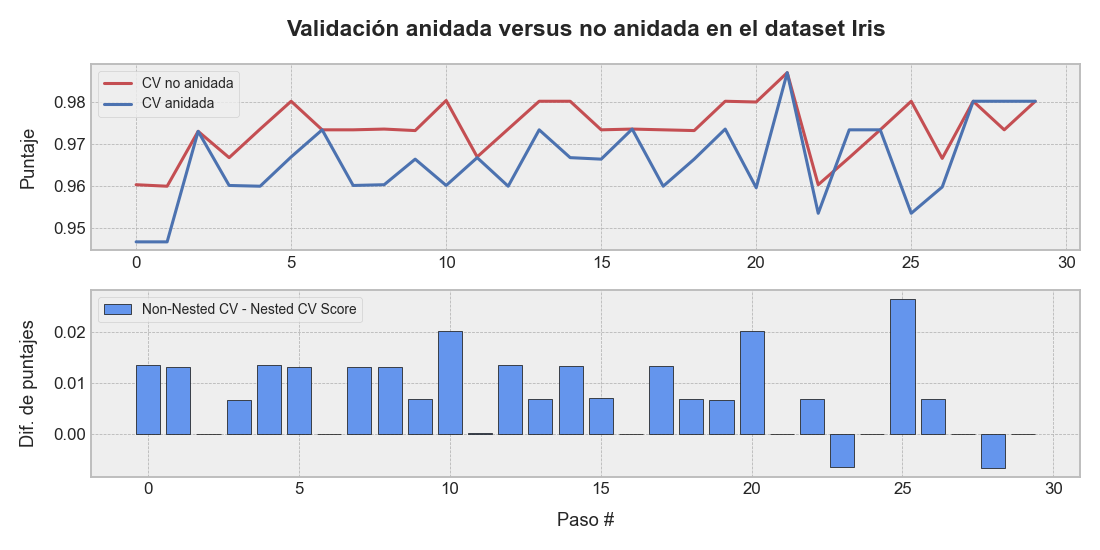

In [71]:
# Visualizamos los resultados.
fig, ax = plt.subplots(figsize=(10, 5), nrows=2, dpi=110)

# Comparativa directa.
(non_nested_scores_line,) = ax[0].plot(non_nested_scores, color="r")
(nested_line,) = ax[0].plot(nested_scores, color="b")
ax[0].set_ylabel("Puntaje", fontsize=12, labelpad=10)
ax[0].legend(
    [non_nested_scores_line, nested_line],
    ["CV no anidada", "CV anidada"],
    bbox_to_anchor=(0, 1.0, 1.0, 0),
    fontsize=9,
)
ax[0].set_title(
    "Validación anidada versus no anidada en el dataset Iris",
    x=0.5,
    y=1.1,
    fontsize="15",
    fontweight="bold",
)
# Barras que señalan las diferencias entre cada paso.
difference_plot = ax[1].bar(range(NUM_TRIALS), score_difference, ec="k", color="cornflowerblue")
ax[1].set_xlabel("Paso #", fontsize=12, labelpad=10)
ax[1].legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 1, 0),
    fontsize=9,
)
ax[1].set_ylabel("Dif. de puntajes", fontsize=12, labelpad=10)
plt.tight_layout();

Podemos observar que la validación cruzada no anidada resulta casi siempre en mejores resultados que el caso anidado. Esto lo podemos comprobar rápidamente en el gráfico de barras, ya que únicamente dos barras apuntan en sentido negativo. Esto pone de manifiesto algo muy importante: La búsqueda exhaustiva no anidada, en efecto, genera resultados sesgados con respecto al conjunto de entrenamiento y algo mayores que cuando removemos ese sesgo al anidar las estrategias de validación cruzada. ◼︎

### Búsqueda aleatorizada (`RandomizedSearchCV`).
Mientras que el uso de una grilla de búsqueda exhaustiva es un método que se usa con frecuencia para la optimización de hiperparámetros, otros métodos resultan más favorables. `RandomizedSearchCV` implementa una **búsqueda aleatorizada** sobre un espacio de hiperparámetros, donde –idealmente– cada hiperparámetro es representado por una distribución de probabilidad sobre los posibles valores que puede tomar cada uno. Esta técnica presenta dos ventajas con respecto a una búsqueda exhaustiva:

- Podemos fijar el número total de iteraciones previo a la implementación de la búsqueda.
- La adición de hiperparámetros que no influencian el desempeño del modelo no impacta negativamente en la eficiencia de la búsqueda.

Nuevamente especificamos el espacio de búsqueda por mdio de un diccionario de Python, de forma a similar a como lo hicimos con `GridSearchCV`. Idealmente, en vez de listas o secuencias, especificamos los valores de cada hiperparámetro por medio del uso de distribuciones teóricas. **<font color='mediumorchid'>Scikit-Learn</font>** acepta varios objetos especializados que representan variables aleatorias, pero con frecuencia usamos los provistos por **<font color='mediumorchid'>Scipy</font>**:

In [72]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

In [73]:
# Cargamos el dataset Iris.
iris = load_iris()
X = iris["data"]
y = iris["target"]

In [74]:
# Definimos el espacio de búsqueda.
param_distributions = {
    "max_depth": stats.randint(low=2, high=8),
    "min_samples_split": stats.randint(low=2, high=32),
    "min_samples_leaf": stats.randint(low=1, high=16),
}

A continuación, definimos nuestro modelo base:

In [75]:
# Inicializamos un modelo de árbol de decisión.
model = DecisionTreeClassifier(random_state=42)

Luego construimos nuestro objeto de búsqueda. `RandomizedSearchCV` dispone de casi los mismos argumentos que `GridSearchCV`. Sumamos el parámetro `n_iter`, que nos permite controlar el número de iteraciones que se llevarán a cabo para realizar la optimización, y que es esencial en esta búsqueda:

In [76]:
# Definimos nuestro buscador.
searcher = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    scoring="f1_macro",
    cv=5,
    n_iter=400,
)

Realizamos nuestra búsqueda aleatorizada:

In [77]:
# Y realizamos la búsqueda.
searcher.fit(X, y)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=400,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9efb514a30>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9efb4cd4f0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9efb514dc0>},
                   scoring='f1_macro')

Y recuperamos los resultados de la validación cruzada. El diccionario resultante tiene exactamente el mismo formato y estructura que el obtenido por medio de `GridSearchCV`:

In [78]:
# Recuperamos los resultados de esta evaluación.
results = pd.DataFrame(searcher.cv_results_)

In [79]:
# Verificamos las primeras filas de estos resultados.
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001677,0.000251,0.002989,0.000403,6,8,25,"{'max_depth': 6, 'min_samples_leaf': 8, 'min_s...",0.966583,0.966583,0.899749,0.866667,1.0,0.939916,0.049013,78
1,0.001357,0.000005,0.002631,0.000016,2,1,3,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,172
2,0.001379,0.000012,0.002631,0.000010,5,5,28,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.966583,1.000000,0.861111,0.866667,1.0,0.938872,0.062452,149
3,0.001352,0.000007,0.002621,0.000008,2,11,19,"{'max_depth': 2, 'min_samples_leaf': 11, 'min_...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,172
4,0.001373,0.000003,0.002623,0.000008,3,9,25,"{'max_depth': 3, 'min_samples_leaf': 9, 'min_s...",0.933333,0.966583,0.899749,0.866667,1.0,0.933266,0.047164,172


Al visualizar los resultados, notaremos un patrón muy distinto de búsqueda:

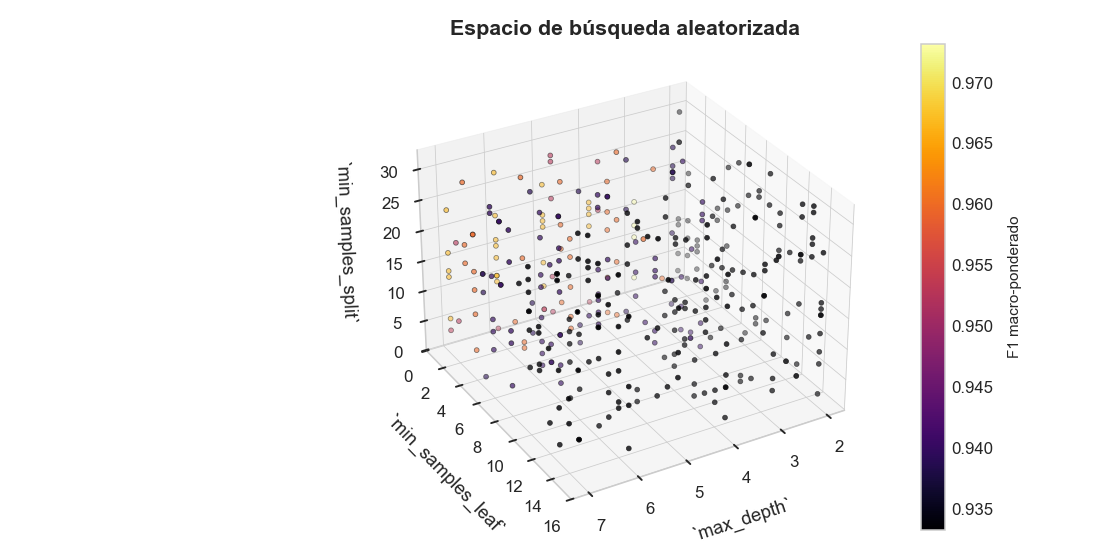

In [80]:
# Visualizamos la grilla completa de búsqueda.
with plt.style.context("seaborn-v0_8-whitegrid"):
    fig = plt.figure(figsize=(10, 5), dpi=110)
    ax = fig.add_subplot(projection="3d")
    p = ax.scatter(
        results["param_max_depth"],
        results["param_min_samples_leaf"],
        results["param_min_samples_split"],
        c=results["mean_test_score"],
        s=10,
        lw=0.5,
        ec="k",
        cmap="inferno"
    )
    cb = fig.colorbar(p)
    cb.set_label("F1 macro-ponderado", fontsize=10, labelpad=10)
    ax.set_xlabel("`max_depth`", fontsize=12, labelpad=10)
    ax.set_ylabel("`min_samples_leaf`", fontsize=12, labelpad=10)
    ax.set_zlabel("`min_samples_split`", fontsize=12, labelpad=10)
    ax.set_title("Espacio de búsqueda aleatorizada", fontsize=14, fontweight="bold")
    ax.view_init(elev=30, azim=60) 
    plt.tight_layout();

Y en efecto, ya no tenemos una malla regular de evaluación. La aleatoriedad de esta búsqueda produce un patrón sin orden definido, ya que, al azar, se escogen valores de las distribuciones provistas para cada hiperparámetro, testeando un total de `n_iter` combinaciones.

**Ejemplo 8.4 – Comparativa entre `GridSearchCV` y `RandomizedSearchCV`**: En este ejercicio, compararemos las técnicas de búsqueda aleatorizada y exhaustiva para la optimización de hiperparámetros en un modelo de SVM lineal con gradiente descendente estocástico (SGD). Todos los hiperparámetros que influencian el aprendizaje del modelo se buscan de forma simultánea (con excepción del número de estimadores, que posee un trade-off entre tiempo y calidad de estimación).

Ambos métodos explorarán exactamente el mismo espacio de búsqueda. El resultado en términos de valores para cada hiperparámetro se espera que sea similar, pero con una enorme diferencia en tiempo de ejecución, a favor de `RandomizedSearchCV`. Asimismo, el desempeño de éste último puede ser ligeramente peor que en `GridSearchCV`, debido al ruido inducido por la aleatorización.

Procedemos pues. Usaremos el dataset **<font color='forestgreen'>DIGITS</font>** que, si no lo recordamos, corresponde a una muestra de imágenes de números escritos con letra manuscrita por muchísimas personas, que van del `0` al `9`:

In [81]:
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
from time import time

In [82]:
# Obtenemos los datos.
X, y = load_digits(return_X_y=True, n_class=3)

A continuación definimos nuestro modelo base:

In [83]:
# Construimos nuestro clasificador SGD.
sgd_model = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)

A continuación, definimos una función sencilla que nos permitirá reportar los resultados asociados a cada búsqueda, en términos de los puntajes medios asociados a cada una:

In [84]:
# Definimos una función utilitaria para reportar los resultados de las búsquedas.
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Modelo con ranking: {0}".format(i))
            print(
                "Puntaje medio de validación: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parámetros: {0}".format(results["params"][candidate]))
            print("")

Ahora procedemos con la búsqueda aleatorizada:

In [85]:
# Diseñamos nuestra búsqueda aleatorizada.
# Partimos con el espacio de búsqueda.
param_distrubutions = {
    "average": [True, False],
    "l1_ratio": stats.uniform(0, 1),
    "alpha": stats.loguniform(1e-2, 1e0),
}
# Ejecutamos la búsqueda aleatorizada.
n_iter = 15
random_search = RandomizedSearchCV(
    sgd_model, param_distributions=param_distrubutions, n_iter=n_iter,
)
# Contamos el tiempo, definiendo primero el inicio de la búsqueda.
start = time()

# Ajustamos...
random_search.fit(X, y)

# Reportamos.
print(
    "RandomizedSearchCV tomó %.2f segundos para %d combinaciones candidatas."
    % ((time() - start), n_iter)
)
report(random_search.cv_results_)

RandomizedSearchCV tomó 1.08 segundos para 15 combinaciones candidatas.
Modelo con ranking: 1
Puntaje medio de validación: 0.994 (std: 0.005)
Parámetros: {'alpha': 0.035976415900777554, 'average': False, 'l1_ratio': 0.16749918047138868}

Modelo con ranking: 2
Puntaje medio de validación: 0.989 (std: 0.011)
Parámetros: {'alpha': 0.2037908240862158, 'average': False, 'l1_ratio': 0.07137543846124828}

Modelo con ranking: 3
Puntaje medio de validación: 0.987 (std: 0.013)
Parámetros: {'alpha': 0.016285586015535616, 'average': True, 'l1_ratio': 0.946545646133925}

Modelo con ranking: 3
Puntaje medio de validación: 0.987 (std: 0.022)
Parámetros: {'alpha': 0.020883733173645662, 'average': False, 'l1_ratio': 0.2534004671786365}



Y ahora con la búsqueda exhaustiva:

In [86]:
# Ahora diseñamos nuestra búsqueda exhaustiva.
# Partimos con la grilla de búsqueda.
param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}
# Ejecutamos la búsqueda exhaustiva.
grid_search = GridSearchCV(sgd_model, param_grid=param_grid)

# Contamos el tiempo, definiendo primero el inicio de la búsqueda.
start = time()

# Ajustamos...
grid_search.fit(X, y)

# Reportamos.
print(
    "GridSearchCV tomó %.2f segundos para %d combinaciones candidatas."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

GridSearchCV tomó 4.04 segundos para 60 combinaciones candidatas.
Modelo con ranking: 1
Puntaje medio de validación: 0.991 (std: 0.010)
Parámetros: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.3333333333333333}

Modelo con ranking: 2
Puntaje medio de validación: 0.989 (std: 0.018)
Parámetros: {'alpha': 0.01, 'average': True, 'l1_ratio': 0.1111111111111111}

Modelo con ranking: 3
Puntaje medio de validación: 0.989 (std: 0.007)
Parámetros: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.4444444444444444}



Y ahí lo tenemos. La búsqueda aleatorizada tardó casi 4 veces menos con una menor cantidad de soluciones candidatas con respecto a la búsqueda aleatorizada, aunque el resultado es ligeramente inferior en calidad, pero bien vale perder un mínimo de calidad al ahorrar todo ese tiempo de ejecución. ◼︎

### Búsqueda con "halving" sucesivo.
**<font color='mediumorchid'>Scikit-Learn</font>** también nos provee de los objetos especializados `HalvingGridSearchCV` y `HalvingRandomSearchCV`, los que permiten explorar espacios de búsqueda de manera similar a las clases `GridSearchCv` y `RandomizedSearchCV`, pero con una filosofía muy especial denominada ***halving* sucesivo** (del inglés *successive halving*, o SH). Esta técnica se basa en una idea sencilla: Hacemos una especie de "torneo" entre soluciones candidatas, en el cual tomamos algunos candidatos y los evaluamos con una cantidad reducida de recursos computacionales en una primera iteración. Sólo algunos de estos candidatos –los mejores– son seleccionados para la próxima iteración, para la cual alocamos un nivel superior de recursos computacionales. Y así sucesivamente.

Los recursos son símiles a las instancias de entrenamiento. Aunque, en realidad, es posible forzar a que el procedimiento de búsqueda use otros recursos. Por ejemplo, `n_estimators` para cualquier modelo de ensamble. Lo importante es que sean los suficientes para finalizar el procedimiento.

El método `HalvingGridSearchCV` usa una colección de parámetros similar a la de `GridSearchCV`, aunque con notables diferencias, entre las que consideramos:

- `factor`: Corresponde al denominado **parámetro de *halving*** de la búsqueda. Por defecto, se tiene que `factor=3`, lo que significa que sólo un tercio de las soluciones candidatas son seleccionadas en cada iteración. En general, si `factor=n`, entonces seleccionamos una fracción de `1/n` soluciones candidatas en cada iteración.
- `resources`: Define el recurso que se incrementará a medida que progresa la búsqueda. Por defecto, su valor es igual al número de instancias de entrenamiento (`n_samples`). También es posible seleccionar cualquier otro parámetro que queramos buscar para nuestro estimador **que acepte valores positivos** (por ejemplo, `n_estimators` en el caso de los ensambles). En este caso, debemos especificar otro parámetro denominado `max_resources` de forma explícita. Este valor también puede ser un número entero (lo suficientemente grande).
- `max_resources`: El número máximo de recursos para cada solución candidata a utilizar en una determinada iteración. Por defecto, `max_resources=n_samples` cuando `resources=n_samples`. Debe definirse explícitamente cuando ésto no es así.
- `min_resources`: El número mínimo de recursos que es permitido utilizar para evaluar una solución candidata en una determinada iteración. Equivalentemente, este parámetro permite definir el número de recursos, denominado `r0`, que son alocados para cada solución candidata en la primera iteración:
    - `"smallest"` es una heurística que fija `r0` a un valor pequeño:
        - `n_splits * 2` cuando `resources=n_samples` para un problema de regresión.
        - `n_classes * n_splits * 2` cuando `resources=n_samples` para un problema de clasificación.
        - `1` cuando `resources != n_samples`.
    - `"exhaustive"` seteará un valor de `r0` tal que la **última** iteración use tantos recursos como sea posible. A saber, la última iteración hará uso del máximo valor menor que `max_resources` que es un múltiplo simultáneo de `factor` y `min_resources`. En general, el uso de `"exhaustive"` da lugar a mejores estimadores, pero suele ser ligeramente más pesado en términos computacionales.

Veremos el uso de `HalvingGridSearchCV` por medio de un ejemplo. El uso de `HalvingRandomSearchCV` es completamente análogo.

**Ejemplo 8.5 – Comparativa entre búsquedas exhaustivas completa y con "halving" sucesivo:** En el siguiente ejercicio, compararemos los resultados obtenidos por `HalvingGridSearchCV` y `GridSearchCV` conforme el uso de un modelo de SVM lineal, ajustando los valores de los hiperparámetros `C` y `gamma`. Para ello, haremos uso de la función `make_classification()` para crear un dataset genérico que representa a un problema de clasificación binaria, siendo `X` unidimensional:

In [87]:
from sklearn.datasets import make_classification
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [88]:
# Construimos nuestro conjunto de datos.
X, y = make_classification(n_samples=1000, random_state=42)

A continuación definimos la grilla de búsqueda. Usaremos la misma en ambos casos, `HalvingGridSearchCV` y `GridSearchCV`:

In [89]:
# Definimos la grilla de búsqueda.
param_grid = {
    "C": [1, 10, 100, 1e3, 1e4, 1e5],
    "gamma": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
}
Cs = param_grid["C"]
gammas = param_grid["gamma"]

Definimos nuestro modelo base:

In [90]:
# Definimos el modelo base.
model = SVC(random_state=42)

Y procedemos con `HalvingGridSearchCV`, midiendo el tiempo de ejecución:

In [91]:
# Definimos el momento de inicio de la búsqueda.
start = time()

# Definimos nuestro buscador con estrategia de "halving" sucesivo.
hgs_searcher = HalvingGridSearchCV(
    estimator=model,
    param_grid=param_grid,
    factor=2,
    random_state=42,
)
# Y ejecutamos nuestra búsqueda.
hgs_searcher.fit(X, y)

# Chequeamos el tiempo de ejecución.
hgs_end = time() - start

Ahora hacemos lo mismo con `GridSearchCV`:

In [92]:
# Definimos el momento de inicio de la búsqueda.
start = time()

# Definimos nuestro buscador con estrategia de "halving" sucesivo.
gs_searcher = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
)
# Y ejecutamos nuestra búsqueda.
gs_searcher.fit(X, y)

# Chequeamos el tiempo de ejecución.
gs_end = time() - start

A continuación definimos una función que nos permitirá construir mapas de calor que muestren los puntajes de cada combinación de hiperparámetros para cada método de búsqueda:

In [93]:
# Definimos una función que nos permitirá construir mapas de calor que comparan
# las evaluaciones de cada estrategia de búsqueda.
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    # Recuperamos los resultados de la búsqueda y los reformateamos.
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[
        ["param_C", "param_gamma"]
    ].astype(float)
    
    # Chequeamos si el buscador usa "halving" sucesivo.
    if is_sh:
        # DataFrame con SH: Obtenemos los valores medios de scoring para la
        # mejor solución encontrada.
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )
    # Inicializamos la imagen con la matriz de puntajes.
    im = ax.imshow(scores_matrix, cmap="viridis")

    # Formateamos el eje X y lo rotulamos.
    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=11)

    # Formateamos el eje Y y lo rotulamos.
    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=11)

    # Rotamos las marcas de graduación y las alineamos.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Nuevamente chequeamos si el buscador usa "halving" sucesivo.
    if is_sh:
        # Construimos una tabla dinámica de resultados por iteración.
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        # Rellenamos cada celda del mapa de calor con las veces en que cada solución
        # "sobrevivió" una evaluación.
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=10,
                )
    # Personalizamos la barra de color.
    if make_cbar:
        # Barra horizontal en la parte inferior del eje
        cbar = fig.colorbar(
            im,
            ax=ax,
            orientation="horizontal",
            pad=0.20,
            fraction=0.08
        )
        cbar.set_label("Puntaje medio de validación", fontsize=12, labelpad=8)

A continuación, construimos los mapas de calor:

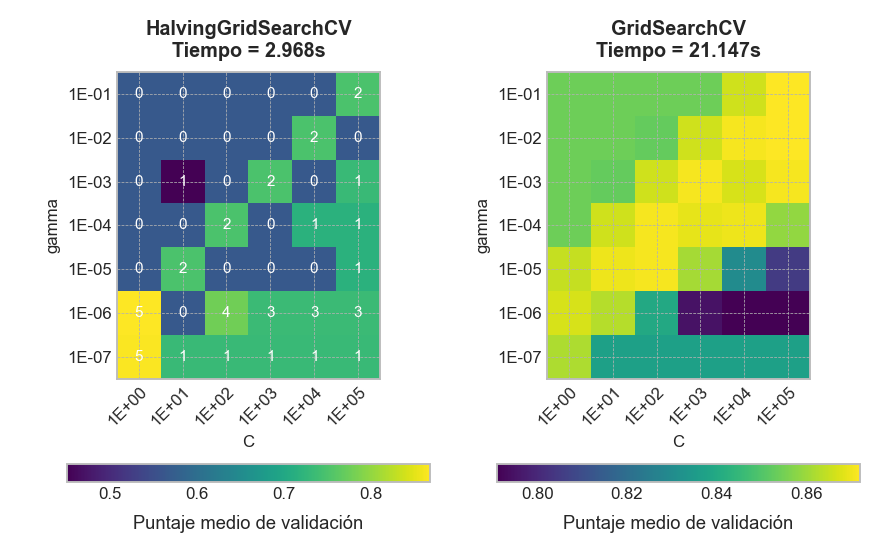

In [94]:
# Visualizamos los resultados.
fig, ax = plt.subplots(figsize=(8, 5), ncols=2, dpi=110)

make_heatmap(ax[0], hgs_searcher, is_sh=True, make_cbar=True)
make_heatmap(ax[1], gs_searcher, make_cbar=True)

ax[0].set_title(
    "HalvingGridSearchCV\nTiempo = {:.3f}s".format(hgs_end),
    fontsize=13, fontweight="bold", pad=10,
)
ax[1].set_title(
    "GridSearchCV\nTiempo = {:.3f}s".format(gs_end),
    fontsize=13, fontweight="bold", pad=10,
)
plt.tight_layout();

Los mapas de calor son tales que el color muestra el valor del puntaje de validación, mientras que los números en el mapa asociado a `HalvingGridSearchCV` representan el número de veces en las cuales la correspondiente solución candidata fue evaluada. Naturalmente, los valores mayores son los asociados a los mejores puntajes, porque fueron los candidatos que "sobrevivieron" hasta el final. Las combinaciones determinadas por `HalvingGridSearchCV` son casi igual de buenas que las encontradas por `GridSearchCV`, pero en 7 veces menos tiempo. ◼︎

### Un último comentario acerca de las métricas de desempeño.
Por defecto, toda estrategia de búsqueda de hiperparámetros en **<font color='mediumorchid'>Scikit-Learn</font>** utiliza la métrica de desempeño definida por el método `score()` del correspondiente estimador. Por defecto, tales métricas corresponden a la exactitud (`accuracy_score()`) para modelos de clasificación, y el coeficiente de determinación (`r2_score()`) para modelos de regresión. Para algunos problemas, otras métricas pueden resultar más adecuadas (por ejemplo, en el caso de problemas de clasificación no balanceados, hemos aprendido en las secciones anteriores que la exactitud, con frecuencia, conduce a conclusiones equivocadas sobre la calidad de un modelo). No existe una guía rápida que sea 100% infalible, puesto que cada problema es un mundo diferente. Pero podemos dar algunas directrices (no escritas en piedra):

1. Para problemas de **clasificación**:
   - **Curva ROC + AUC (`roc_curve()` y `roc_auc_score()`)**: Para evaluar la **capacidad de ranking global** de un modelo; es decir, su capacidad de discriminar globalmente entre las clases de interés. En casos multinomiales, utilizaremos variantes OvR (one-versus-rest) u OvO (one-versus-one), según sea el caso.
   - **Curva de precisión versus sensibilidad + PR–AUC (`precision_recall_curve()` y `average_precision_score()`):** Preferible con clases desbalanceadas; se centra en la clase positiva. Con *PR-AUC* nos referimos al área bajo la curva de precisión versus sensibilidad de un modelo de clasificación.
   - **F1 normal, macro o micro-ponderado (`f1_score()`):** Cuando importan los aciertos sobre verdaderos positivos y el umbral óptimo de discriminación; usamos la opción de macro-ponderación si hay desbalance entre clases.

2. Para problemas de **regresión:**
    - **MAE (error medio absoluto):** Interpretable en unidades de la variable de respuesta; robusto a outliers moderados.
    - **RMSE (error cuadrático medio en raíz):** Penaliza más los errores grandes; útil si los grandes desvíos son costosos en términos de decisión.
    - **MAPE (error medio porcentual absoluto):** Error relativo (solo si $y>0$ y sin ceros); permite comparar desempeño en distintas escalas.
    - **$r^{2}$ (coeficiente de determinación):** Fracción de varianza explicada por el modelo con respecto a la "señal " real; complementa pero no sustituye a los errores absolutos o relativos.

## Optimización Bayesiana de hiperparámetros con **<font color='mediumorchid'>Optuna</font>**.
Las estrategias de búsqueda provistas por **<font color='mediumorchid'>Scikit-Learn</font>** son excelentes dentro de sus limitaciones. Las técnicas implementadas revisten mayor fuerza bruta y evaluaciones que pueden ser aleatorizadas o exhaustivas, pero no son verdaderas rutinas de optimización en el sentido de que no se basan en la formulación clásica de un problema de optimización como tal. Para recurrir a rutinas de este tipo, es necesario buscar fuera de **<font color='mediumorchid'>Scikit-Learn</font>**. Es así como llegamos a **<font color='mediumorchid'>Optuna</font>**.

### Una explicación (breve) sobre la teoría de optimización Bayesiana.
Dentro de los varios frameworks existentes para optimizar los hiprparámetros de un modelo –que son compatibles con **<font color='mediumorchid'>Scikit-Learn</font>**–, **<font color='mediumorchid'>Optuna</font>** resulta particularmente sencillo de aprender y con una base teórica robusta fundamentada en la **teoría de optimización Bayesiana**.

Esta teoría apunta a resolver problemas del tipo

$$\begin{gathered}\begin{array}{ll}\displaystyle \min_{\mathbf{x} \in \mathcal{X}}&f\left( \mathbf{x} \right)\\ \mathrm{s.a.} :&\mathbf{x} \in \mathcal{X}\end{array}\end{gathered} \tag{8.2}$$

Donde $f$ es una función objetivo desconocida, que comúnmente llamamos **caja negra** (del inglés **black box**). La funcion $f$ también podrá ser conocida, pero ser costosa de evaluar en un tiempo razonable, sin gradientes disponibles (ya sea por discontinuidades o costo) y con una presencia de ruido significativo. En la formulación (8.2), $\mathbf{x}\in \mathbb{R}^{n}$ es un **vector** en $\mathbb{R}^{n}$ y $\mathcal{X}$ representa al **espacio de búsqueda** del problema.

Sin pérdida de generalidad, explicaremos el caso unidimensional, ya que la extensión a $\mathbb{R}^{n}$ es directa haciendo sólo algunos cambios algebraicos. Consideraremos $y=f(x)+\varepsilon$, donde $\varepsilon \sim \mathcal{N}(0, \sigma^{2})$ es ruido Gaussiano de media nula y varianza $\sigma^{2}$. **Nuestro objetivo es encontrar cuasi-óptimos del problema (8.2) con pocas evaluaciones de $f$**, lo que excluye enfoques que requieran muestrear densamente el espacio de búsqueda $\mathcal{X}$. Esto, naturalmente, deja fuera cualquier opción de evaluar exhaustivamente muchas soluciones candidatas (como haríamos con `GridSearchCV` o `RandomizedSearchCV`).

La optimización Bayesiana clásica reemplaza esta descripción de $f$ por otra de tipo probabilística, del tipo $P\left( f\  |\  \mathcal{D}_{t} \right)$, entrenado con un historial $\mathcal{D}_{t} =\left\{ \left( x_{i},y_{i} \right) \right\}_{i=1}^{t}$, similar a un conjunto de entrenamiento para modelos de aprendizaje supervisado. En general, empleamos un **proceso Gaussiano** (GP) por su capacidad para proporcionar predicciones con incertidumbre: Para todo $x$, la correspondiente distribución a posteriori induce una distribución normal $f(x) \sim \mathcal{N} \left( \mu_{t} \left( x \right) ,\sigma_{t}^{2} \left( x \right) \right)$. Alternativas populares incluyen **bosques aleatorios Bayesianos**, **TPE (Tree-structured Parzen Estimators)** y **regresores neuronales Bayesianos**, útiles cuando el número de instancias de entrenamiento es grande o cuando existen variables categóricas. Sobre este sustituto se define una **función de adquisición** $\alpha_{t}(x)$ que cuantifica el valor esperado de evaluar $f$ en $x$, equilibrando **exploración** (para grandes valores de $\sigma_{t}$) y **explotación** (para valores pequeños de $\mu_{t}$).

Las funcions de adquisición pueden ser variadas. Un ejemplo corresponde a la **función de mejora esperada** (EI, del inglés *expected improvement*), definida como

$$\mathrm{EI}_{t} \left( x \right) =\mathrm{E} \left[ \max_{x} \left( 0,f^{\ast}-f(x) \right) |\mathcal{D}_{t} \right] \tag{8.3}$$

Donde $f^{\ast}$ es el mejor valor observado para $f$. Otro ejemplo es la **función de probabilidad de mejora** (PI):

$$\mathrm{PI}_{t} \left( x \right) =\max_{x} \left[ P\left( f\left( x \right) \leq f^{\ast}-\xi \right) \right] \tag{8.4}$$

Donde $\xi> 0$ es un **margen de mejora**.

Cualquiera sea, la función de adquisición no es costosa de evaluar y es siempre diferenciable (conforme el sustituto), por lo que puede optimizarse con métodos numéricos para proponer el próximo punto $x_{t+1}\in \underset{x}{\mathrm{argmax}} \left( \alpha_{t} \left( x \right) \right)$, o –incluso a veces– con métodos exactos si ésta es convexa, aunque este último escenario es muy difícil que se dé en la realidad.

El **ciclo general** de una solución Bayesiana para un problema de optimización suele ser como sigue:

1. **Inicialización** por medio de un pequeño diseño de espacio de búsqueda. Estos diseños son estándar y existen varios que podemos implementar (por ejemplo, [muestreo de tipo hipercubo latino](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) o [secuencia de Sobol](https://en.wikipedia.org/wiki/Sobol_sequence)).
2. **Ajuste del sustituto** $P\left( f\  |\  \mathcal{D}_{t} \right)$.
3. **Optimización** de $\alpha_{t}(x)$ para elegir el siguiente punto $x_{t+1}$.
4. **Evaluación** (en general, costosa) de $f(x_{t+1})$ y actualización a $\mathcal{D}_{t+1}$.
5. **Detención** si $\alpha_{t}$ no mejora en un número dado de iteraciones, denominado **paciencia**.

En resumen, **la optimización Bayesiana resuelve problemas de optimización global costosos y sin gradientes** al fijar una "creencia" probabilística sobre la función objetivo $f$ que **cuantifica incertidumbre** y decidir la próxima evaluación maximizando una función de adquisición que **codifica el trade-off exploración–explotación**. Esta combinación produce **eficiencia muestral** significativa con presupuestos de evaluación reducidos (digamos, recursos computacionales), y sus variantes modernas permiten manejar restricciones, múltiples objetivos, fidelidades y evaluación en paralelo, haciendo de la optimización Bayesiana un framework versátil no sólo para el ajuste de hiperparámetros, sino que para otros sujetos de interés, como el diseño experimental y la calibración de modelos complejos.

### Estimador de Parzen con estructura de tipo árbol (TPE).
**<font color='mediumorchid'>Optuna</font>** opera, por defecto, con un algoritmo de optimización Bayesiana denominado **estimador de Parzen con estructura de tipo árbol** (**TPE**, del inglés *tree-structured Parzen estimator*). Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right) :\  \mathbf{X} \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento constituido por una matriz de diseño $\mathbf{X}$ y un vector de valores de respuesta $\mathbf{y}$. Cuando buscamos la mejor combinación de hiperparámetros para un modelo, lo que hacemos equivale a buscar un vector $\mathbf{w} \in \mathcal{W}$ constituido por los valores individuales de cada hiperparámetro, siendo $\mathcal{W}$ el correspondiente **espacio de búsqueda**. Ses $\mathcal{L}$ el error global (riesgo empírico) cometido por un modelo $f$ que predice $\mathbf{y}$ en términos de $\mathbf{X}$. El vector $\mathbf{w}$, por supuesto, busca minimizar $\mathcal{L}$ conforme

$$\mathcal{L} \left( \mathbf{w} |\mathbf{X} ,\mathbf{y} \right) =\ell_{v} \left( f\left( \mathbf{X} ,\mathbf{y} |\mathbf{w} \right) ,f\left( \mathbf{X}_{v} \right) \right) \tag{8.5}$$

Donde $\ell_{v}$ es la función de pérdida usada para evaluar la calidad del modelo $f$ en el conjunto de validación (por ejemplo, conforme un esquema de validación cruzada) y $\mathbf{X}_{v}$ es una matriz de diseño que contiene los datos de ese conjunto de validación.

**<font color='mediumorchid'>Optuna</font>** es un framework de optimización Bayesiana que organiza cualquier procedimiento de búsqueda de hiperparámetros en experimentos (denominados *studies*), *trials* (evaluaciones de $\mathbf{w}$), una técnica de muestreo que incluye una función de adquisición (en este caso, por defecto, asociado al algoritmo TPE) y un podador o *pruner*, que permite eliminar *trials* poco prometedores de nuestro experimento, similar a la estrategia de "halving" sucesivo. El motor que realiza este trabajo por defecto en **<font color='mediumorchid'>Optuna</font>** no es un proceso Gaussiano, sino precisamente el algoritmo TPE, que es un método Bayesiano no paramétrico que modela la densidad de hiperparámetros condicionada al desempeño del modelo.

En lugar de modelar la probabilidad $P(\mathbf{y}|\mathbf{w})$, como lo haría un proceso Gaussiano arbitrario, el algoritmo TPE intenta modelar las probabilidades $P\left( \mathbf{w} |\mathbf{y} \right)$ y $P(\mathbf{y})$. Sea $\hat{y}_{k}$ la salida observada al evaluar $\mathbf{w}_{k}$. Fijado un percentil $\gamma\in (0, 1)$ y el umbral $y^{\ast}$ tal que $P\left( \hat{y}_{i} \leq y^{\ast} \right) =\gamma$, separamos los *trials* históricos en

$$\mathcal{D}_{g} =\left\{ \left( \mathbf{w}_{k} ,\hat{y}_{k} \right) :\  \hat{y}_{k}\leq y^{\ast} \right\} \  \  \wedge \  \  \mathcal{D}_{b} =\left\{ \left( \mathbf{w}_{k} ,\hat{y}_{k} \right) :\  \hat{y}_{k}>y^{\ast} \right\} \tag{8.6}$$

Sobre cada subconjunto se ajustan estimadores de densidad de Parzen (los que corresponden a estimadores de densidad de kernel –KDEs– univariantes condicionados por la estructura en árbol del espacio de búsqueda). Es decir,

$$\ell \left( \mathbf{w} \right) \approx P\left( \mathbf{w}_{k} |\hat{y}_{k} \leq y^{\ast} \right) \  \  \wedge \  \  g\left( \mathbf{w} \right) \approx P\left( \mathbf{w}_{k} |\hat{y}_{k} >y^{\ast} \right) \tag{8.7}$$

La función de mejora esperada (EI), bajo este esquema en particular, es monótonamente creciente con respecto a la razón $\ell \left( \mathbf{w} \right) /g\left( \mathbf{w} \right)$. Por lo tanto, el algoritimo TPE propone un nuevo valor de $\mathbf{w}$ solucionando el problema

$$\mathbf{w}_{t+1} \in \underset{\mathbf{w} \in \mathcal{W}}{\mathrm{argmax}} \left( \frac{\ell \left( \mathbf{w} \right)}{g\left( \mathbf{w} \right)} \right)_{\mathbf{w} =\mathbf{w}_{t}} \tag{8.8}$$

Operacionalmente, **<font color='mediumorchid'>Optuna</font>** muestrea candidatos desde $\ell$ y elige el que maximiza la razón $\ell \left( \mathbf{w} \right) /g\left( \mathbf{w} \right)$, lo que equilibra explotación (modos de $\ell$) y exploración (regiones en $\mathcal{W}$ donde $g$ es grande y $\ell$ es muy pequeño).

<p style="text-align: center;">Algoritmo (8.1): Estimación de Parzen con estructura de tipo árbol (TPE)</p>

**`def`** `TPE`$(\mathcal{D}_0,\ \mathcal{W},\ \gamma,\ M,\ T)$:<br>
>Entrada del algoritmo: Historial de inicio $\mathcal{D}_{0} =\left\{ \left( \mathbf{w}_{k} ,y_{k} \right) \right\}_{k=1}^{t_{0}}$, espacio de busqueda con estructura de tipo árbol $\mathcal{W}$ (continuos, enteros, categóricos y dependencias condicionales); percentil $\gamma \in (0, 1)$, número de candidatos por iteración $M$, presupuesto total de *trials* $T$.<br>
>
>Inicializar $t\longleftarrow t_{0}$ y el mejor vector $\mathbf{w}^{\ast} \longleftarrow \underset{\left( \mathbf{w}_{k} ,y_{k} \right) \in \mathcal{D}_{0}}{\mathrm{argmin}} y_{k}$.<br>
>
>**`while`** $t\leq T$:<br>
>>**Umbral de elite:** Sea $y^{\ast}$ el $\gamma$-percetil de $\left\{ y_{k} \right\}_{k=1}^{t}$. Es decir, $P\left( y_{i}\leq y^{\ast} \right) =\gamma$. Particionamos el historial conforme: $\mathcal{D}_{g} =\left\{ \left( \mathbf{w}_{k} ,y_{k} \right) :\  y_{k}\leq y^{\ast} \right\} \wedge \mathcal{D}_{b} =\left\{ \left( \mathbf{w}_{k} ,y_{k} \right) :\  y_{k}>y^{\ast} \right\}$.<br>
>>**Modelamiento de densidades de Parzen:** Para cada dimensión (y rama condicional) de $\mathbf{w}$, ajustamos KDEs univariantes con un ancho de banda y soporte adecuados, obteniendo $\ell \left( \mathbf{w} \right) \approx P\left( \mathbf{w} |y\leq y^{\ast} \right) \wedge g\left( \mathbf{w} \right) \approx P\left( \mathbf{w} |y>y^{\ast} \right)$.<br>
>>**Propuesta de soluciones candidatas:** Muestreamos $M$ soluciones candidatas independientes desde $\ell$, digamos $\left\{ \mathbf{w}^{\left( s \right)} \right\}_{s=1}^{M}\sim \ell$. Para cada solución candidata, evaluamos la **razón de adquisición** $\alpha (\mathbf{w}^{\left( s \right)} )=\frac{\ell \left( \mathbf{w}^{\left( s \right)} \right)}{g\left( \mathbf{w}^{\left( s \right)} \right)}$.<br>
>>Seleccionamos $\mathbf{w}_{t+1} =\underset{s\in \left\{ 1,...,M \right\}}{\mathrm{argmax}} \  \alpha \left( \mathbf{w}^{\left( s \right)} \right)$.<br>
>>**Evaluación y poda (este paso es opcional):** Ejecutamos el *trial* con $\mathbf{w}_{t+1}$. Evaluamos $y_{t+1}=\mathcal{L} \left( \mathbf{w}_{t+1} \right)$. Si optamos por poda, se interrumpe el *trial* si sus valores intermedios son peores que el percentil de referencia; en ese caso, $y_{t+1}$ se registra como "podado" y continuamos.<br>
>>**Actualización:** Actualizamos el historial $\mathcal{D}_{t+1} \longleftarrow \mathcal{D}_{t} \cup \left\{ \left( \mathbf{w}_{t+1} ,t_{t+1} \right) \right\}$, con $\mathbf{w}^{\ast} \longleftarrow \underset{\left( \mathbf{w}_{t+1} ,y_{t+1} \right) \in \mathcal{D}_{t+1}}{\mathrm{argmin}} \left( y^{\ast},y_{t+1} \right) \wedge t\longleftarrow t+1$.<br>
>>**`return`** Vector final $\mathbf{w}^{\ast}$ y el registro $\mathcal{D}_{T}$.

Algunas observaciones prácticas respecto del algoritmo:

- Elección de $\gamma$ y $M$: Un $\gamma$ pequeño concentra $\ell$ en el "top" de observaciones, lo que se traduce es más explotación. Un $M$ grande mejora el máximo scoring conforme la razón de adquisición $\ell(\mathbf{w})/g(\mathbf{w})$ con un costo computacional razonable, puesto que operar sobre KDEs no es particularmente exigente.
- Poda y eficiencia: La poda reduce sustancialmente el costo computacional cuando la métrica intermedia es predictiva del resultado final (lo que suele ser el caso).
- Espacios mixtos y condicionales: El algoritmo TPE maneja de forma natural categorías y enteros, y su esquema de tipo árbol evita combinaciones inviables cuando hay dependencias condicionales entre las variables.
- Más allá del algoritmo TPE: **<font color='mediumorchid'>Optuna</font>** también ofrece otros algoritmos de búsqueda y muestreo. Resulta esencial, para entender la ventaja entre uno u otro, leer la documentación.
- Restricciones: Se integran como penalizaciones en $\mathbf{y}$ o como modelos auxiliares de factibilidad. Esto permite que **<font color='mediumorchid'>Optuna</font>** no se limite únicamente a resolver problemas de optimización de hiperparámetros, sino cualquier problema general (de hecho, **<font color='mediumorchid'>Optuna</font>** puede resultar muy últil a la hora de abordar problemas de naturaleza prescriptiva).

**Ejemplo 8.6 – Una introducción al uso básico de <font color='mediumorchid'>Optuna</font>:** Vamos a ilustrar la forma más básica de utilizar **<font color='mediumorchid'>Optuna</font>** para optimizar los hiperparámetros del mismo modelo de árbol de decisión que hemos testeado para las estrategias `GridSearchCV` y `RandomizedSearchCV` en ejemplos anteriores. Para ello, nos valdremos de la función `make_scorer()` de `sklearn.metrics` para crear una métrica de F$_{1}$ macro-ponderado que sea mejor cuando más grande sea, ahorránonos el definir manualmente el tipo de puntaje a utilizar, usando un esquema de validación cruzada.

Haremos uso de dos clases muy importantes de **<font color='mediumorchid'>Optuna</font>**: `TPESampler`, que corresponde a un objeto que implementa un muestreo basado en el **algoritmo TPE** conforme lo visto en el algoritmo (8.1); y `MedianPruner`, que implementa una función de poda basada en la denominada **regla detención por mediana**, y que permite realizar la poda de una solución candidata si el resultado de ésta (al evaluar la función objetivo) es peor que la mediana de los resultados previos. Permite, en definitiva, detener cualquier *trial* que no sea prometedor al compararlo con los anteriores mediante una regla muy sencilla de computar:

In [95]:
import optuna

In [96]:
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.metrics import f1_score, make_scorer

Definimos ahora nuestro conjunto de datos, basado nuevamente en el dataset **<font color='forestgreen'>IRIS</font>**:

In [97]:
# Cargamos el dataset Iris.
iris = load_iris()
X = iris["data"]
y = iris["target"]

Debido al poder de **<font color='mediumorchid'>Optuna</font>**, añadiremos un total de `100` variables con ruido Gaussiano para dificultar un poco la tarea de nuestro modelo:

In [98]:
# Añadimos 100 variables de ruido Gaussiano al dataset.
rng = np.random.default_rng(42)
noise = rng.normal(size=(X.shape[0], 100))
X_aug = np.hstack([X, noise])

Empleamos ahora un procedimiento de validación cruzada para crear nuestra función de evaluación de los resultados de cada *trial*. La razón por la que usamos `make_scorer()` es porque queremos que la evaluación sea realizada por medio de una validacion cruzada estratificada por *trial* aplicando el puntaje F$_{1}$ macro-ponderado:

In [99]:
# Definimos una estrategia de validación cruzada estratificada.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

Ahora definimos los rangos de valores que evaluaremos en nuestra búsqueda de soluciones prometedoras. Notemos que este **espacio de búsqueda** se define igual que cuando implementamos las estrategias típicas de **<font color='mediumorchid'>Scikit-Learn</font>**, por medio de un diccionario de Python:

In [100]:
# Definimos los rangos de los parámetros a buscar.
param_ranges = {
    "max_depth": (1, 20),
    "min_samples_split": (2, 20),
    "min_samples_leaf": (1, 20),
}

Aquí es cuando las cosas comienzan a ponerse más diferentes. Generaremos una función utilitaria que nos ayudará a evaluar cada solución candidata en nuestro experimento. Esto es necesario porque, una vez definamos la función objetivo de dicho experimento, esta función utilitaria será la encargada de evaluar la calidad de nuestras soluciones. Notemos que este procedimiento es más bien *sofisticado*, porque –por lo general– las métricas provistas por **<font color='mediumorchid'>Scikit-Learn</font>** resultan más que suficientes. Así que estamos matando dos pájaros de un tiro:

In [101]:
# Función utilitaria que nos ayudará a evaluar nuestras métricas de desempeño.
def evaluate_params(params):
    max_depth = int(params["max_depth"])
    min_samples_split = int(params["min_samples_split"])
    min_samples_leaf = int(params["min_samples_leaf"])
    min_samples_split = max(min_samples_split, 2)
    min_samples_leaf = max(min_samples_leaf, 1)

    # Chequeamos y acotamos `min_samples_split` para evitar contratiempos.
    if min_samples_split < 2 * min_samples_leaf:
        min_samples_split = 2 * min_samples_leaf

    # Definimos el modelo base.
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    # Obtenemos los puntajes por medio de una estrategia sencilla de validación cruzada.
    scores = cross_val_score(model, X_aug, y, cv=cv, scoring=scorer)
    return float(np.mean(scores))

A continuación, definimos una lista vacía en la cual almacenaremos los resultados de nuestro experimento:

In [102]:
# Lista vacía en la que almacenaremos todos los registros de la optimización.
trials_log = []

A continuación definimos nuestra función objetivo, denominada `objective()`. El único argumento de ésta es un objeto llamado `trial`, que es del tipo `optuna.trial.Trial` y permite a **<font color='mediumorchid'>Optuna</font>** sugerir valores del espacio de búsqueda y construir las soluciones candidatas. También permite gestionar el estado de cada *trial* y definir algunos aspectos específicos del mismo, entre los cuales consideramos:

- `suggest_int()`, que es el método que hemos elegido para que nuestro experimento seleccione soluciones candidatas a partir del espacio de búsqueda provisto. Este método simplemente sugiere combinaciones de números enteros, lo que es compatible con los hiperparámetros que hemos definido previamente.
- `number`, que es un atributo que permite recuperar el número de cada *trial*.

La estructura de la función objetivo es muy estándar, aunque es muy común que, en código no productivo, la función `objective()` utilice variables que no fueron explícitamente definidas como argumentos, aunque por supuesto esta no es una práctica recomendada en un producto final. Nuestra función objetivo retornará el puntaje asociado a nuestro experimento conforme la métrica que hemos definido previamente:

In [103]:
# Definimos la función objetivo a utilizar.
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", *param_ranges["max_depth"]),
        "min_samples_split": trial.suggest_int("min_samples_split", *param_ranges["min_samples_split"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", *param_ranges["min_samples_leaf"]),
    }
    score = evaluate_params(params)
    trials_log.append({
        "number": trial.number,
        **params,
        "value": score,
        "state": "COMPLETE"
    })
    return score

A continuación creamos nuestro experimento, lo que hacemos por medio de la función `create_study()`, directamente desde **<font color='mediumorchid'>Optuna</font>**. Esta función consiste, entre otros, de los siguientes argumentos:

- `storage`: Permite definir dónde almacenaremos nuestro experimento. En general, no usaremos esta opción, salvo que creemos un espacio dedicado por medio de un dashboard provisto **<font color='mediumorchid'>Optuna</font>** en una librería separada, llamada `optuna-dashboard`. Hablaremos de ésto más adelante.
- `sampler`: Permite definir nuestra estrategia de muestreo de soluciones candidatas. Es acá donde proveemos a **<font color='mediumorchid'>Optuna</font>** del algoritmo TPE, por medio del objeto `TPESampler`, para el cual definimos además una semilla aleatoria fija (por medio del parámetro `seed`) a fin de garantizar la reproducibilidad de nuestro experimento. El algoritmo TPE suele ser la opción más usada en problemas como éstos, ya que es un algoritmo que resuelve problemas de optimización con un único objetivo, pero existen otras opciones más avanzadas.
- `direction`: Permite definir la dirección de la optimización, que puede ser `"minimize"` o `"maximize"`. También podemos usar el objeto especializado `StudyDirection`, pero eso queda fuera del alcance de estos apuntes.
- `pruner`: Permite definir nuestra estrategia de poda, que en nuestro caso será `MedianPruner`. Seteamos el parámetro `n_warmup_steps=10` a fin de indicarle a **<font color='mediumorchid'>Optuna</font>** que la poda estará desactivada hasta que el *trial* correspondiente exceda los `10` pasos.
- `study_name`: Nombre con el que bautizaremos a nuestro estudio.

Procedemos entonces:

In [104]:
# Creamos nuestro experimento.
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10),
    study_name="iris_dataset_hyperparameter_opt",
)

[I 2025-12-14 17:12:57,807] A new study created in memory with name: iris_dataset_hyperparameter_opt


A continuación procedemos con la optimización. Para ello, directamente sobre nuestro objeto `study`, aplicamos el método `optimize()`. Este método se vale de varios argumentos, entre los cuales consideramos:

- `func`: La función objetivo a optimizar (en nuestro caso, `objective`).
- `n_trials`: El número de *trials* para nuestro experimento. El estudio continuará hasta que se cumpla el último *trial* definido por `n_trials`.
- `timeout`: Número de punto flotante que representa cuántos segundos durará el estudio, en caso de no haber definido explícitamente un número de *trials*.
- `n_jobs`: Número de procesadores disponibles que serán usados para trabajar en paralelo la optimización. Si `n_jobs=-1`, usamos todos los *cores* disponibles en nuestra CPU.
- `callbacks`: Lista de Python que define las funciones de *callback* que serán utilizadas al final de cada *trial*. Esta es una opción más sofisticada y orientada a problemas de optimización más generales, que permite construir restricciones sobre los valores que toma la función objetivo en cada caso, entre otras cosas.
- `show_progress_bar`: Parámetro Booleano que permite decidir si mostraremos una barra de progreso de nuestro experimento. La barra se muestra en un formato de JavaScript, y requiere de **<font color='mediumorchid'>IPython</font>** para visualizarse correctamente.

Procedemos:

In [105]:
# Y llevamos a cabo la optimización.
study.optimize(func=objective, n_trials=60, show_progress_bar=True)

  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-12-14 17:12:57,899] Trial 0 finished with value: 0.9399164578111947 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.9399164578111947.
[I 2025-12-14 17:12:57,948] Trial 1 finished with value: 0.9397483608009924 and parameters: {'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9399164578111947.
[I 2025-12-14 17:12:57,990] Trial 2 finished with value: 0.9399164578111947 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.9399164578111947.
[I 2025-12-14 17:12:58,030] Trial 3 finished with value: 0.9399164578111947 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.9399164578111947.
[I 2025-12-14 17:12:58,077] Trial 4 finished with value: 0.9397483608009924 and parameters: {'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0

Una vez ejecutada la optimización, rescatamos la mejor combinación de hiperparámetros y el mejor resultado obtenido del F$_{1}$ macro-ponderado por medio de los atributos `best_params` y `best_value`:

In [106]:
# Rescatamos la solución óptima encontrada y el valor del score.
best_params = study.best_params
best_value = study.best_value

A continuación, llevamos nuestro registro a un formato de DataFrame:

In [107]:
# Creamos un DataFrame con nuestro registro del experimento completo.
trials_df = pd.DataFrame(trials_log)

Y verificamos los mejores resultados:

In [108]:
# Chequeamos los mejores resultados.
trials_df.sort_values(by="value", ascending=False).head()

,number,max_depth,min_samples_split,min_samples_leaf,value,state
59,59,13,20,3,0.946465,COMPLETE
55,55,12,9,3,0.946465,COMPLETE
42,42,5,11,13,0.939916,COMPLETE
29,29,13,4,18,0.939916,COMPLETE
31,31,3,6,11,0.939916,COMPLETE


In [109]:
# Mostramos los resultados en pantalla.
print(f"Mejor solución encontrada: {best_params}")
print(f"Máximo F1 macro-ponderado obtenido: {best_value}")

Mejor solución encontrada: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3}
Máximo F1 macro-ponderado obtenido: 0.9464651527809422


Chequeamos pues que hemos llegado a un resultado más que aceptable. Visualizamos nuestros resultados:

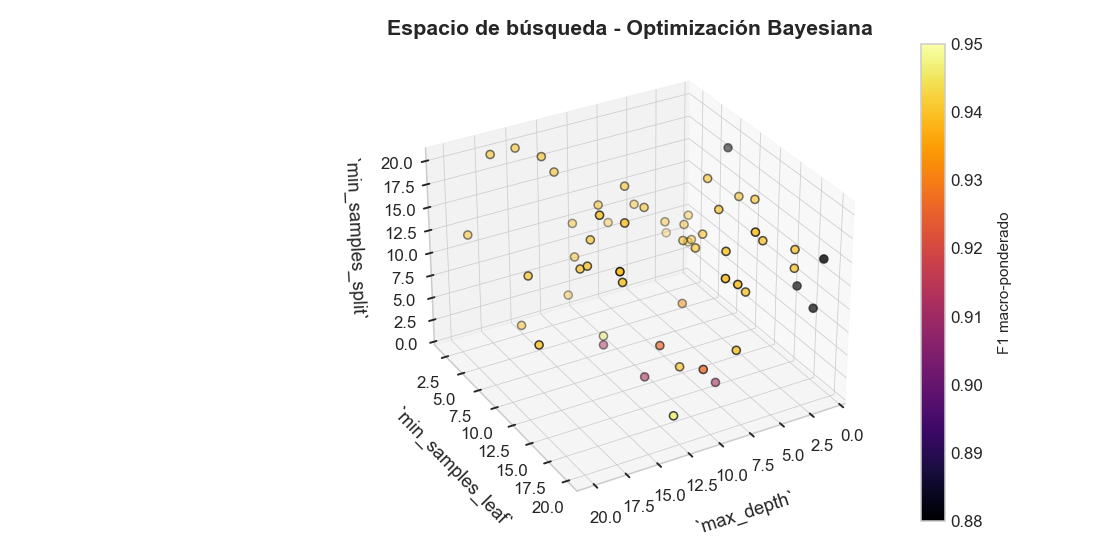

In [110]:
# Visualizamos el espacio de búsqueda.
with plt.style.context("seaborn-v0_8-whitegrid"):
    fig = plt.figure(figsize=(10, 5), dpi=110)
    ax = fig.add_subplot(111, projection='3d')

    # Recuperamos los valores a graficar de nuestro registro.
    xs = trials_df["max_depth"].astype(int).values
    ys = trials_df["min_samples_split"].astype(int).values
    zs = trials_df["min_samples_leaf"].astype(int).values
    cs = trials_df["value"].values

    # Creamos nuestro gráfico.
    p = ax.scatter(
        xs, ys, zs, c=cs, s=28, ec="k", lw=1.0,
        vmin=0.88, vmax=0.95, cmap="inferno",
    )
    cb = fig.colorbar(p)
    cb.set_label("F1 macro-ponderado", fontsize=10, labelpad=10)
    ax.set_xlabel("`max_depth`", fontsize=12, labelpad=10)
    ax.set_ylabel("`min_samples_leaf`", fontsize=12, labelpad=10)
    ax.set_zlabel("`min_samples_split`", fontsize=12, labelpad=10)
    ax.set_title("Espacio de búsqueda - Optimización Bayesiana", fontsize=14, fontweight="bold")
    ax.view_init(elev=30, azim=60) 
    plt.tight_layout();

Y ahí tenemos. La optimización Bayesiana provista por **<font color='mediumorchid'>Optuna</font>** es capaz de encontrar una solución igual de buena o mejor que las encontradas por las estrategias provistas por **<font color='mediumorchid'>Scikit-Learn</font>**, con un método mucho más robusto y que sí implementa una rutina de optimización sobre el espacio de búsqueda en vez de realizar evaluaciones exhaustivas (fijas o aleatorizadas). ◼︎